# Librerias necesarias

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    RidgeCV,
    ElasticNetCV,
    LassoCV,
    SGDRegressor,
    LogisticRegression
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
     mean_squared_error, 
     r2_score, 
     mean_absolute_error,
     classification_report, 
     confusion_matrix,
     ConfusionMatrixDisplay,
     balanced_accuracy_score, 
     log_loss,
     roc_curve, 
     roc_auc_score, 
     auc,
     accuracy_score
)
import shap

# Carga de datos

In [109]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path = "weatherAUS.csv"
df = pd.read_csv(file_path, sep=",", engine="python")

# Limpieza y transformacion de datos

Elimino la columna 'Unnamed: 0' porque es un indice que esta de mas.


In [110]:
df = df.drop("Unnamed: 0", axis=1)

Segun el enunciado, unicamente nos interesan las ciudades Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport por lo que filtro el DataSet para quedarme unicamente con los datos de dichas ciudades.

Tambien elimino de una vez la variable 'Location' debido a que el enunicado declara que se pueden considerar como una unica ubicacion.


In [111]:
ciudades = [
    " Adelaide",
    "Canberra",
    "Cobar",
    "Dartmoor",
    "Melbourne",
    "MelbourneAirport",
    "MountGambier",
    "Sydney",
    "SydneyAirport",
]
df = df[df["Location"].isin(ciudades)]
df = df.drop("Location", axis=1)

### Split de datos

Hago el split en df_train y df_test a partir de una fecha determinada para dejar aproximadamente un 80% de mis datos en Train y 20% en Test.

In [112]:
# Convierto la columna 'Date' a tipo datetime
df["Date"] = pd.to_datetime(df["Date"])

In [113]:
# Fecha más antigua
fecha_mas_antigua = df['Date'].min()
fecha_mas_reciente = df['Date'].max()

print(f'Fecha mas antigua: {fecha_mas_antigua}')
print(f'Fecha mas reciente: {fecha_mas_reciente}')

Fecha mas antigua: 2007-11-01 00:00:00
Fecha mas reciente: 2017-06-24 00:00:00


La fecha mas antigua del dataset es 01-11-2007 y la mas reciente es 24-06-2017. 
Decido hacer el split de datos a partir de la fecha 01-01-2016, concentrando aproximadamente el 80% de datos para el conjunto de entrenamiento, y el 20% restante para el conjunto de test.

In [114]:
fecha_limite = "2016-01-01"

df_train = df[df["Date"] < fecha_limite]

df_test = df[df["Date"] >= fecha_limite]

print("Tamaño del conjunto de entrenamiento:", len(df_train))
print("Tamaño del conjunto de prueba:", len(df_test))

Tamaño del conjunto de entrenamiento: 20713
Tamaño del conjunto de prueba: 4328


---


### Tipos de datos y valores nulos

Observo una descripcion, el tipo de dato y los valores nulos de cada variable.


In [115]:
df_train.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,20713,20271.000000,20284.000000,19981.000000,19461.000000,17369.000000,19159.000000,20366.000000,20382.000000,20023.000000,20068.000000,20008.000000,20016.000000,15867.000000,15593.000000,20258.000000,20265.000000,19981.000000
mean,2012-04-24 22:18:46.596823040,10.955991,21.647510,2.062940,4.675207,6.809471,42.885015,15.986252,20.811500,69.661489,50.862916,1018.303134,1016.178991,4.572761,4.687616,15.168388,20.142990,2.061859
min,2007-11-01 00:00:00,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,5.000000,1.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,2010-06-10 00:00:00,7.100000,16.500000,0.000000,2.200000,3.700000,33.000000,9.000000,15.000000,58.000000,37.000000,1013.400000,1011.300000,1.000000,2.000000,11.100000,15.200000,0.000000
50%,2012-04-17 00:00:00,10.600000,20.800000,0.000000,4.000000,7.300000,41.000000,15.000000,20.000000,71.000000,50.000000,1018.500000,1016.300000,6.000000,6.000000,14.700000,19.300000,0.000000
75%,2014-03-24 00:00:00,14.900000,25.800000,1.000000,6.400000,10.000000,52.000000,20.000000,26.000000,83.000000,64.000000,1023.400000,1021.200000,7.000000,7.000000,18.900000,24.200000,1.000000
max,2015-12-31 00:00:00,30.500000,46.800000,119.400000,64.800000,14.300000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.700000,46.100000,119.400000
std,NaN,5.741061,6.573869,6.446013,3.401770,3.853102,14.462229,9.778937,9.218541,18.437859,20.014269,7.370028,7.236090,2.814362,2.619433,5.655393,6.410891,6.445336


In [116]:
df_train.dtypes

Date                datetime64[ns]
MinTemp                    float64
MaxTemp                    float64
Rainfall                   float64
Evaporation                float64
Sunshine                   float64
WindGustDir                 object
WindGustSpeed              float64
WindDir9am                  object
WindDir3pm                  object
WindSpeed9am               float64
WindSpeed3pm               float64
Humidity9am                float64
Humidity3pm                float64
Pressure9am                float64
Pressure3pm                float64
Cloud9am                   float64
Cloud3pm                   float64
Temp9am                    float64
Temp3pm                    float64
RainToday                   object
RainTomorrow                object
RainfallTomorrow           float64
dtype: object

In [117]:
df_train.isnull().sum()

Date                   0
MinTemp              442
MaxTemp              429
Rainfall             732
Evaporation         1252
Sunshine            3344
WindGustDir         1557
WindGustSpeed       1554
WindDir9am          1229
WindDir3pm           401
WindSpeed9am         347
WindSpeed3pm         331
Humidity9am          690
Humidity3pm          645
Pressure9am          705
Pressure3pm          697
Cloud9am            4846
Cloud3pm            5120
Temp9am              455
Temp3pm              448
RainToday            732
RainTomorrow         732
RainfallTomorrow     732
dtype: int64

Observo que las variables 'RainToday', 'RainTomorrow' y 'RainfallTomorrow' tienen igual cantidad de valores nulos.

Me fijo en que registros las tres columnas son nulas, son unicamente 570 registros, lo que representa aproximadamente un 2% de mi dataset, por lo que decido eliminarlos.


In [119]:
# Registros de df_train donde las 3 variables son Nulas.
df_train[
    df_train["RainToday"].isnull()
    & df_train["RainTomorrow"].isnull()
    & df_train["RainfallTomorrow"].isnull()
]

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6967,2011-08-09,7.4,13.0,NaN,NaN,NaN,WNW,28.0,WSW,W,...,51.0,1013.0,1011.1,8.0,7.0,8.2,12.5,NaN,NaN,NaN
6968,2011-08-10,6.5,16.7,NaN,NaN,NaN,WSW,26.0,NNW,W,...,64.0,1010.5,1007.7,NaN,8.0,11.4,12.7,NaN,NaN,NaN
7445,2012-11-29,23.9,41.7,NaN,11.2,NaN,SW,50.0,NNE,NNW,...,16.0,1011.5,1008.4,1.0,4.0,29.8,40.9,NaN,NaN,NaN
32570,2014-11-28,NaN,23.3,NaN,3.4,11.9,ENE,37.0,E,E,...,46.0,NaN,1021.3,3.0,2.0,NaN,22.3,NaN,NaN,NaN
46854,2011-06-04,4.4,13.2,NaN,2.2,0.6,NaN,NaN,NNW,WNW,...,58.0,NaN,NaN,8.0,NaN,10.6,11.9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81030,2009-02-28,NaN,NaN,NaN,8.0,4.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81031,2009-03-01,NaN,NaN,NaN,4.0,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81032,2009-03-02,NaN,NaN,NaN,3.8,9.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81033,2009-03-03,NaN,NaN,NaN,8.0,1.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
df_train = df_train[
    ~(
        df_train["RainToday"].isnull()
        & df_train["RainTomorrow"].isnull()
        & df_train["RainfallTomorrow"].isnull()
    )
]

In [121]:
print("Nulos RainToday:", df_train["RainToday"].isnull().sum())
print("Nulos RainTomorrow:", df_train["RainTomorrow"].isnull().sum())
print("Nulos RainfallTomorrow:", df_train["RainfallTomorrow"].isnull().sum())

Nulos RainToday: 162
Nulos RainTomorrow: 162
Nulos RainfallTomorrow: 162


En cada variable quedaron un total de 162 nulos, vuelvo a observar pero esta vez de a pares, en que variables hay nulos a la vez


In [122]:
# Observo de a pares df_train
print(
    "Nulos RainToday y RainTomorrow:",
    (df_train["RainToday"].isnull() & df_train["RainTomorrow"].isnull()).sum(),
)
print(
    "Nulos RainToday y RainfallTomorrow:",
    (df_train["RainToday"].isnull() & df_train["RainfallTomorrow"].isnull()).sum(),
)
print(
    "Nulos RainTomorrow y RainfallTomorrow:",
    (df_train["RainTomorrow"].isnull() & df_train["RainfallTomorrow"].isnull()).sum(),
)

Nulos RainToday y RainTomorrow: 0
Nulos RainToday y RainfallTomorrow: 0
Nulos RainTomorrow y RainfallTomorrow: 162


Procedo a eliminar los registros nulos de las variables 'RainTomorrow' y 'RainfallTomorrow'.


In [123]:
df_train[df_train["RainTomorrow"].isnull() & df_train["RainfallTomorrow"].isnull()]

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6292,2009-09-03,12.0,23.8,0.0,6.4,NaN,N,41.0,NNE,NNW,...,38.0,1016.3,1013.3,7.0,3.0,17.1,22.2,No,NaN,NaN
6966,2011-08-08,3.5,16.0,0.0,4.6,NaN,W,44.0,W,W,...,39.0,1014.7,1011.7,7.0,5.0,9.1,15.4,No,NaN,NaN
7444,2012-11-28,19.5,38.0,2.0,NaN,NaN,NaN,NaN,NaN,NNW,...,25.0,NaN,1010.0,2.0,2.0,26.6,36.6,Yes,NaN,NaN
31035,2010-06-18,9.8,18.0,0.6,3.0,9.6,NaN,NaN,W,W,...,39.0,1017.1,1015.5,NaN,NaN,12.1,17.8,No,NaN,NaN
31148,2010-10-09,15.8,18.9,0.0,5.2,0.0,ESE,31.0,ESE,ENE,...,55.0,1026.4,1025.3,NaN,NaN,17.0,18.3,No,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69427,2014-11-24,15.7,19.9,2.0,7.8,0.4,N,63.0,WSW,SW,...,88.0,1009.1,1006.5,7.0,NaN,17.5,18.3,Yes,NaN,NaN
69437,2014-12-04,17.6,27.7,8.6,1.8,11.8,SSE,35.0,SE,SSE,...,54.0,1010.2,1008.1,7.0,6.0,20.8,25.9,Yes,NaN,NaN
69453,2014-12-20,12.6,23.8,0.0,5.4,13.4,S,35.0,SSW,ESE,...,41.0,1019.3,1017.5,NaN,NaN,16.4,22.4,No,NaN,NaN
69470,2015-01-06,17.6,NaN,0.0,6.6,11.6,S,35.0,ENE,SSE,...,NaN,1020.2,NaN,3.0,NaN,20.7,NaN,No,NaN,NaN


In [124]:
df_train = df_train[
    ~(df_train["RainTomorrow"].isnull() & df_train["RainfallTomorrow"].isnull())
]

### Matriz de correlacion

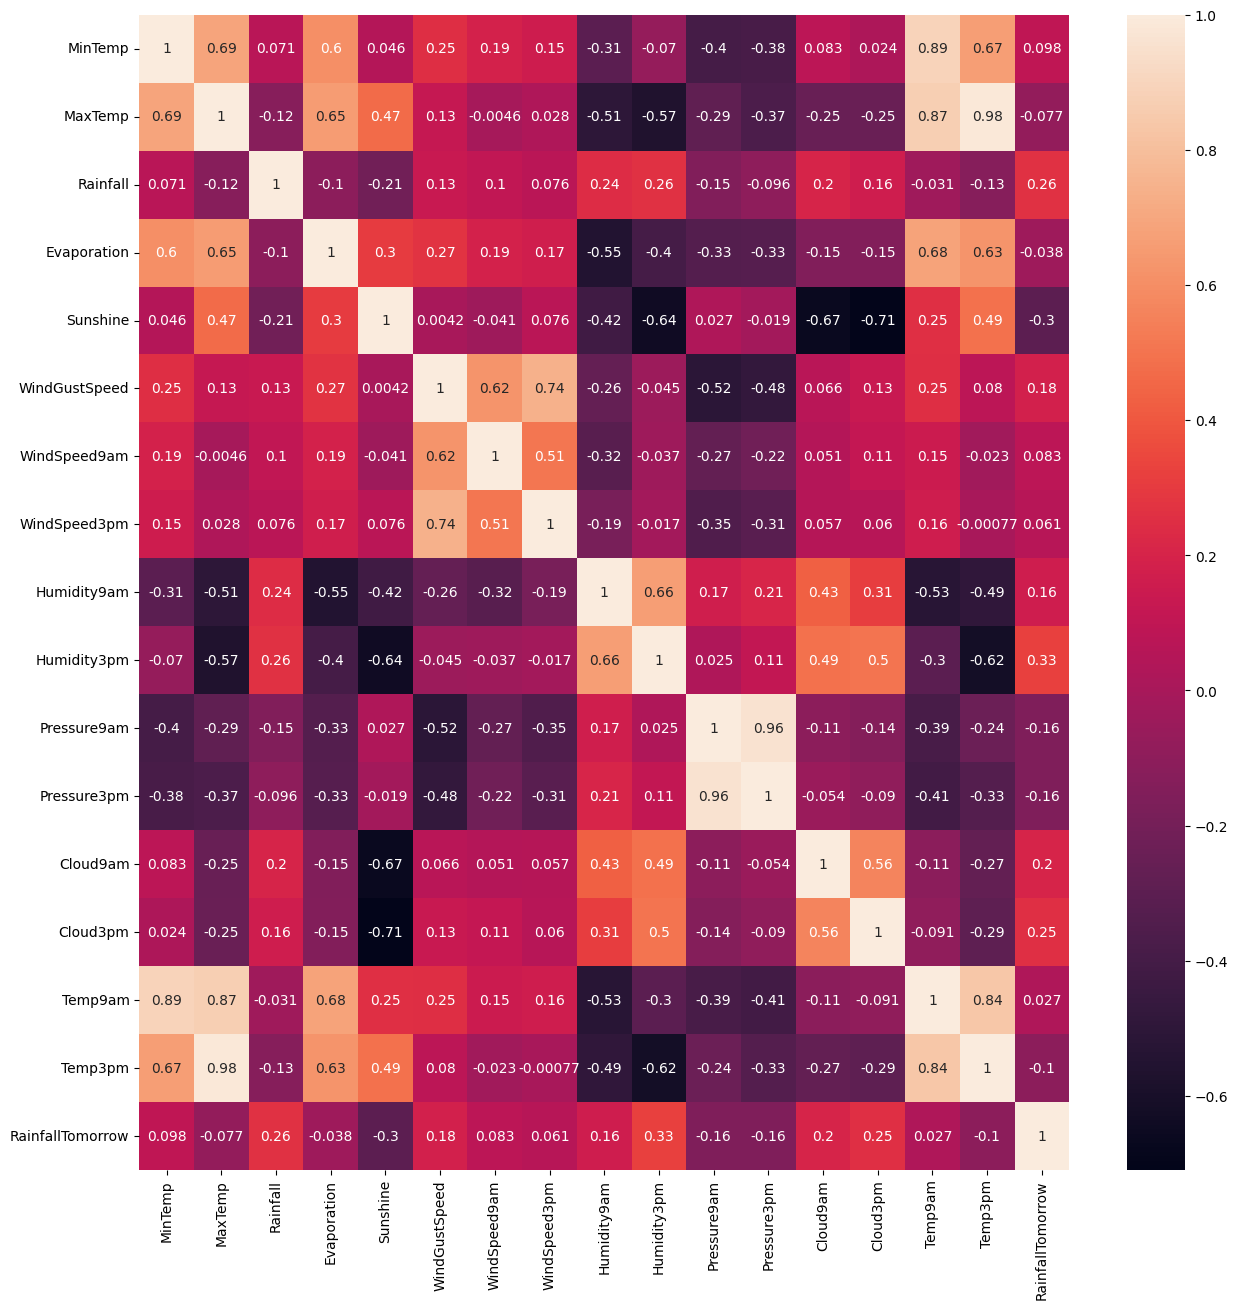

In [125]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    df_train[
        [
            "MinTemp",
            "MaxTemp",
            "Rainfall",
            "Evaporation",
            "Sunshine",
            "WindGustSpeed",
            "WindSpeed9am",
            "WindSpeed3pm",
            "Humidity9am",
            "Humidity3pm",
            "Pressure9am",
            "Pressure3pm",
            "Cloud9am",
            "Cloud3pm",
            "Temp9am",
            "Temp3pm",
            "RainfallTomorrow",
        ]
    ].corr(),
    annot=True,
)
plt.show()

Para rellenar valores nulos, decidi agregar una columna a mi df donde especifico el **Bimestre del año** al que pertenece cada registro, esto lo hago para tener de alguna manera los datos mas segmentados y no calcular una Media, Mediana, o lo que corresponda sobre todos los datos juntos ya que por ejemplo, las temperaturas, vientos, lluvias, etc. pueden no ser lo mismo al inicio del año como por la mitad o al final.


In [126]:
def determinar_bimestre(fecha):
    mes = fecha.month
    if 1 <= mes <= 2:
        return "Bimestre 1"
    elif 3 <= mes <= 4:
        return "Bimestre 2"
    elif 5 <= mes <= 6:
        return "Bimestre 3"
    elif 7 <= mes <= 8:
        return "Bimestre 4"
    elif 9 <= mes <= 10:
        return "Bimestre 5"
    else:
        return "Bimestre 6"

In [127]:
df_train["Bimestre"] = df_train["Date"].apply(lambda x: determinar_bimestre(x))

df_test["Bimestre"] = df_test["Date"].apply(lambda x: determinar_bimestre(x))

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\174503825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Bimestre"] = df_test["Date"].apply(lambda x: determinar_bimestre(x))


### Variable: Rainfall


In [128]:
print(df_train["Rainfall"].isnull().sum())

162


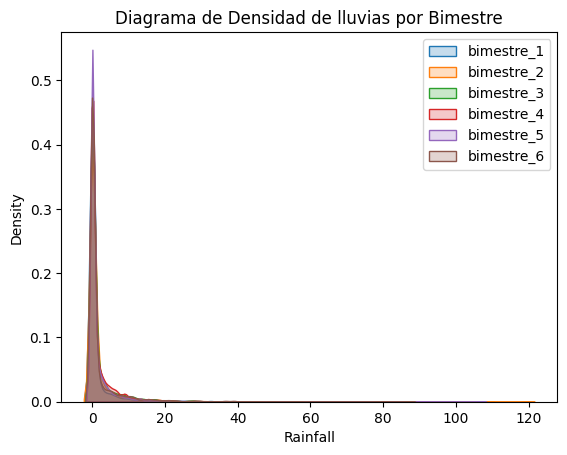

In [129]:
# Diagrama de densidades de la variable RainFall
bimestre_1 = df_train[df_train["Bimestre"] == "Bimestre 1"]
bimestre_2 = df_train[df_train["Bimestre"] == "Bimestre 2"]
bimestre_3 = df_train[df_train["Bimestre"] == "Bimestre 3"]
bimestre_4 = df_train[df_train["Bimestre"] == "Bimestre 4"]
bimestre_5 = df_train[df_train["Bimestre"] == "Bimestre 5"]
bimestre_6 = df_train[df_train["Bimestre"] == "Bimestre 6"]


bandwidth = 0.5
sns.kdeplot(
    data=bimestre_1["Rainfall"], fill=True, label="bimestre_1", bw_adjust=bandwidth
)
sns.kdeplot(
    data=bimestre_2["Rainfall"], fill=True, label="bimestre_2", bw_adjust=bandwidth
)
sns.kdeplot(
    data=bimestre_3["Rainfall"], fill=True, label="bimestre_3", bw_adjust=bandwidth
)
sns.kdeplot(
    data=bimestre_4["Rainfall"], fill=True, label="bimestre_4", bw_adjust=bandwidth
)
sns.kdeplot(
    data=bimestre_5["Rainfall"], fill=True, label="bimestre_5", bw_adjust=bandwidth
)
sns.kdeplot(
    data=bimestre_6["Rainfall"], fill=True, label="bimestre_6", bw_adjust=bandwidth
)
plt.title("Diagrama de Densidad de lluvias por Bimestre")
plt.xlabel("Rainfall")
plt.legend()

Puedo apreciar que la densidad de lluvia no depende del bimestre, por lo que, en este caso, no haria falta hacer esta diferenciacion.


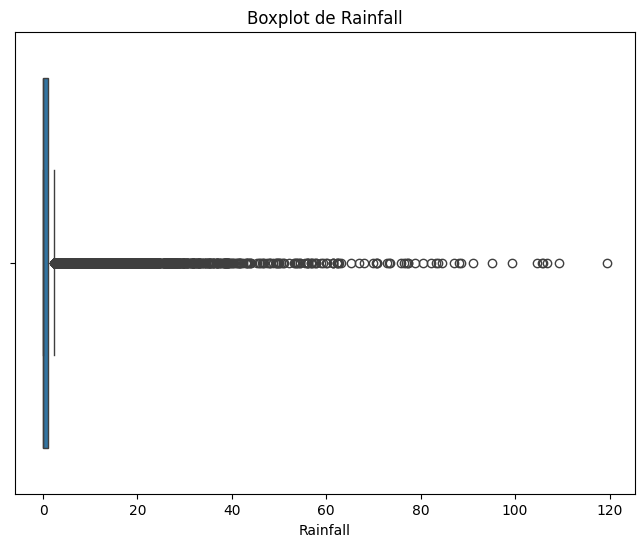

In [130]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Rainfall", data=df_train)
plt.title("Boxplot de Rainfall")
plt.show()

Veo una gran presencia de valores Outliers por lo que me inclino a usar la Mediana como medida para rellenar los valores nulos de la variable RainFall


In [131]:
mediana_por_dia_train = df_train.groupby(df["Date"].dt.date)["Rainfall"].median()

df_train["Rainfall"] = df_train.apply(
    lambda row: (
        mediana_por_dia_train[row["Date"].date()]
        if pd.isnull(row["Rainfall"])
        else row["Rainfall"]
    ),
    axis=1,
)

mediana_por_dia_test = df_test.groupby(df["Date"].dt.date)["Rainfall"].median()

df_test["Rainfall"] = df_test.apply(
    lambda row: (
        mediana_por_dia_test[row["Date"].date()]
        if pd.isnull(row["Rainfall"])
        else row["Rainfall"]
    ),
    axis=1,
)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\4147259352.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Rainfall"] = df_test.apply(


##### Variable: Evaporation


In [132]:
print(df_train["Evaporation"].isnull().sum())

1240


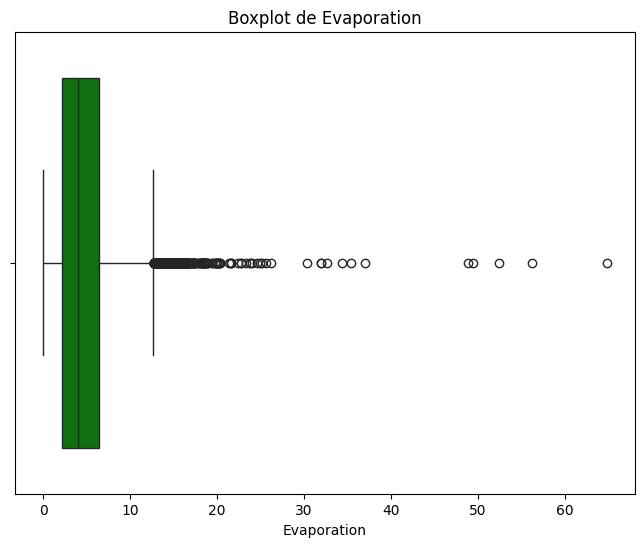

In [133]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Evaporation", data=df_train, color="green")
plt.title("Boxplot de Evaporation")
# plt.ylabel("MaxTemp")
plt.show()

Veo una gran presencia de valores Outliers por lo que me inclino a usar la Mediana como medida para rellenar los valores nulos de la variable **Evaporation**


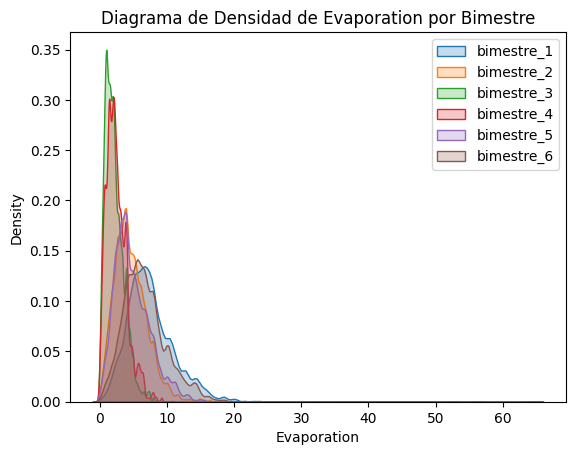

In [134]:
# Diagrama de densidades de la variable Evaporation
bimestre_1 = df_train[df_train["Bimestre"] == "Bimestre 1"]
bimestre_2 = df_train[df_train["Bimestre"] == "Bimestre 2"]
bimestre_3 = df_train[df_train["Bimestre"] == "Bimestre 3"]
bimestre_4 = df_train[df_train["Bimestre"] == "Bimestre 4"]
bimestre_5 = df_train[df_train["Bimestre"] == "Bimestre 5"]
bimestre_6 = df_train[df_train["Bimestre"] == "Bimestre 6"]


bandwidth = 0.5
sns.kdeplot(
    data=bimestre_1["Evaporation"], fill=True, label="bimestre_1", bw_adjust=bandwidth
)
sns.kdeplot(
    data=bimestre_2["Evaporation"], fill=True, label="bimestre_2", bw_adjust=bandwidth
)
sns.kdeplot(
    data=bimestre_3["Evaporation"], fill=True, label="bimestre_3", bw_adjust=bandwidth
)
sns.kdeplot(
    data=bimestre_4["Evaporation"], fill=True, label="bimestre_4", bw_adjust=bandwidth
)
sns.kdeplot(
    data=bimestre_5["Evaporation"], fill=True, label="bimestre_5", bw_adjust=bandwidth
)
sns.kdeplot(
    data=bimestre_6["Evaporation"], fill=True, label="bimestre_6", bw_adjust=bandwidth
)
plt.title("Diagrama de Densidad de Evaporation por Bimestre")
plt.xlabel("Evaporation")
plt.legend()

En este caso se puede apreciar una variacion en la densidad de la variable Evaporation respecto del bimestre.


In [135]:
bim = df_train.groupby("Bimestre")
medians = bim["Evaporation"].median()

for bimestre, median in medians.items():
    df_train.loc[
        (df_train["Bimestre"] == bimestre) & (df_train["Evaporation"].isnull()),
        "Evaporation",
    ] = median


for bimestre, median in medians.items():
    df_test.loc[
        (df_test["Bimestre"] == bimestre) & (df_test["Evaporation"].isnull()),
        "Evaporation",
    ] = median

##### Variable: Sunshine


In [136]:
print(df_train["Sunshine"].isnull().sum())

3331


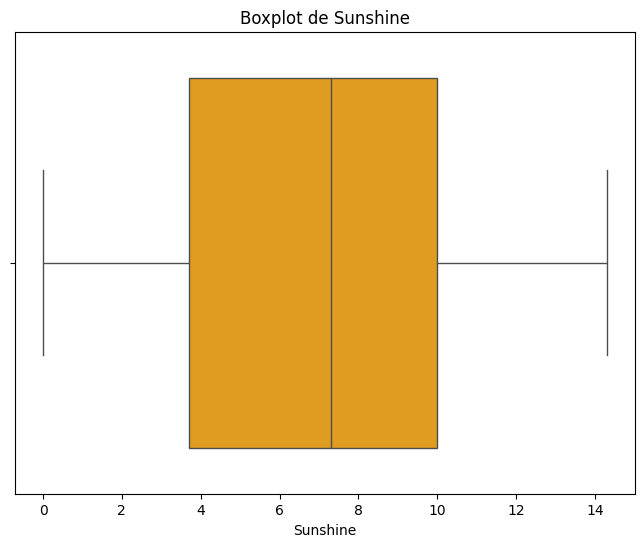

In [137]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Sunshine", data=df_train, color="orange")
plt.title("Boxplot de Sunshine")
plt.show()

La distribucion de la variable Sunshine se ve bastante balanceada y sin presencia de outliers por lo que utilizo la **Media** para imputar a los valores nulos.


In [138]:
df_train["Sunshine"] = df_train.groupby(df_train["Date"].dt.day)["Sunshine"].transform(
    lambda x: x.fillna(x.mean())
)

df_test["Sunshine"] = df_test.groupby(df_test["Date"].dt.day)["Sunshine"].transform(
    lambda x: x.fillna(x.mean())
)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\1948954026.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Sunshine"] = df_test.groupby(df_test["Date"].dt.day)["Sunshine"].transform(


##### Variables: WindGustDir, WindDir9am y WindDir3pm


In [139]:
print(df_train["WindGustDir"].isnull().sum())
print(df_train["WindDir9am"].isnull().sum())
print(df_train["WindDir3pm"].isnull().sum())

1482
1149
338


Relleno los valores faltantes para cada variable utilizando la **Moda** de cada dia.


In [140]:
df_train["WindGustDir"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindGustDir"
].transform(lambda x: x.fillna(x.mode().iloc[0]))
df_train["WindDir9am"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindDir9am"
].transform(lambda x: x.fillna(x.mode().iloc[0]))
df_train["WindDir3pm"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindDir3pm"
].transform(lambda x: x.fillna(x.mode().iloc[0]))


df_test["WindGustDir"] = df_test.groupby(df_test["Date"].dt.day)[
    "WindGustDir"
].transform(lambda x: x.fillna(x.mode().iloc[0]))
df_test["WindDir9am"] = df_test.groupby(df_test["Date"].dt.day)["WindDir9am"].transform(
    lambda x: x.fillna(x.mode().iloc[0])
)
df_test["WindDir3pm"] = df_test.groupby(df_test["Date"].dt.day)["WindDir3pm"].transform(
    lambda x: x.fillna(x.mode().iloc[0])
)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2500600425.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindGustDir"] = df_test.groupby(df_test["Date"].dt.day)[
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2500600425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindDir9am"] = df_test.groupby(df_test["Date"].dt.day)["WindDir9am"].transform(
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2500600425.py:18: SettingWithCopyWarning: 
A value is trying to be 

##### Variables: WindGustSpeed, WindSpeed9am y WindSpeed3pm


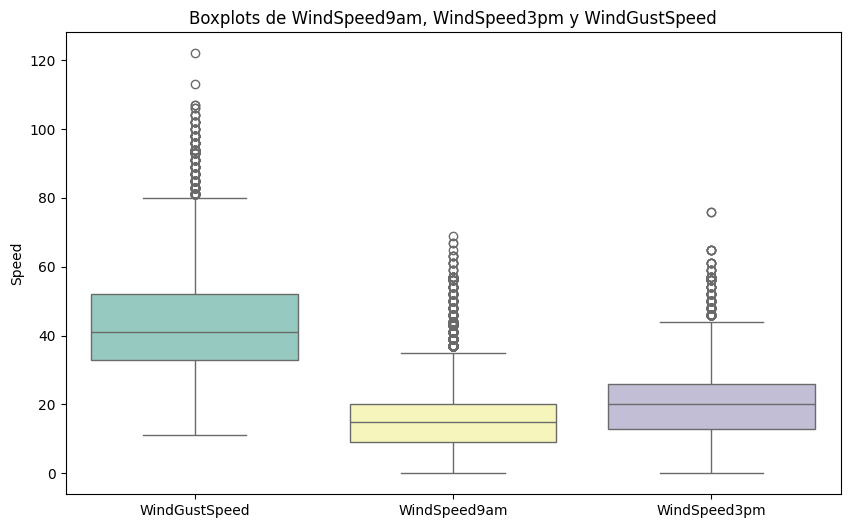

In [141]:
data_to_plot = df_train[["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm"]]

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_to_plot, palette="Set3")
plt.title("Boxplots de WindSpeed9am, WindSpeed3pm y WindGustSpeed")
plt.ylabel("Speed")
plt.show()

Se observa una gran presencia de outlaiers en las 3 variables por lo que procedo a imputar los valores nulos utilizando la **Mediana**.


In [142]:
df_train["WindGustSpeed"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindGustSpeed"
].transform(lambda x: x.fillna(x.median()))
df_train["WindSpeed9am"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindSpeed9am"
].transform(lambda x: x.fillna(x.median()))
df_train["WindSpeed3pm"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindGustSpeed"
].transform(lambda x: x.fillna(x.median()))


df_test["WindGustSpeed"] = df_test.groupby(df_test["Date"].dt.day)[
    "WindGustSpeed"
].transform(lambda x: x.fillna(x.median()))
df_test["WindSpeed9am"] = df_test.groupby(df_test["Date"].dt.day)[
    "WindSpeed9am"
].transform(lambda x: x.fillna(x.median()))
df_test["WindSpeed3pm"] = df_test.groupby(df_test["Date"].dt.day)[
    "WindGustSpeed"
].transform(lambda x: x.fillna(x.median()))

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\3221081509.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindGustSpeed"] = df_test.groupby(df_test["Date"].dt.day)[
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\3221081509.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindSpeed9am"] = df_test.groupby(df_test["Date"].dt.day)[
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\3221081509.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Genero una nueva columna llamada 'Dif_WindSpeed' imputandole el valor correspondiente a la diferencia de las columnas 'WindSpeed9am' y 'WindSpeed3pm' **( 'WindSpeed9am' - 'WindSpeed3pm' )**


In [143]:
df_train["WindSpeed_Difference"] = df_train["WindSpeed9am"] - df_train["WindSpeed3pm"]
df_train.drop(["WindSpeed9am", "WindSpeed3pm"], axis=1, inplace=True)


df_test["WindSpeed_Difference"] = df_test["WindSpeed9am"] - df_test["WindSpeed3pm"]
df_test.drop(["WindSpeed9am", "WindSpeed3pm"], axis=1, inplace=True)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2649069239.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindSpeed_Difference"] = df_test["WindSpeed9am"] - df_test["WindSpeed3pm"]
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2649069239.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["WindSpeed9am", "WindSpeed3pm"], axis=1, inplace=True)


##### Variables: Humidity9am, Humidity3pm, Cloud9am, Cloud3pm, Pressure9am y Pressure3pm


In [144]:
print(df_train["Humidity9am"].isnull().sum())
print(df_train["Humidity3pm"].isnull().sum())
print(df_train["Cloud9am"].isnull().sum())
print(df_train["Cloud3pm"].isnull().sum())
print(df_train["Pressure9am"].isnull().sum())
print(df_train["Pressure3pm"].isnull().sum())

265
222
4267
4527
279
273


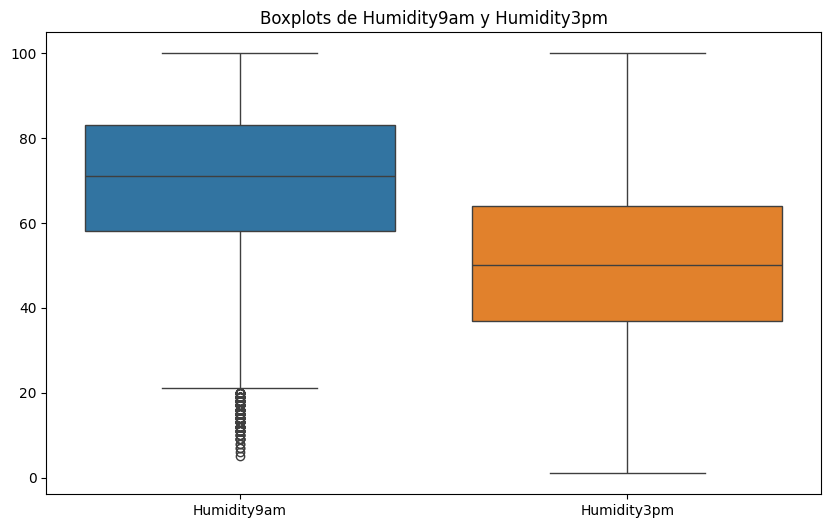

In [145]:
data_to_plot = df_train[["Humidity9am", "Humidity3pm"]]
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_to_plot)
plt.title("Boxplots de Humidity9am y Humidity3pm")
plt.show()

In [146]:
df_train["Humidity9am"] = df_train.groupby(df_train["Date"].dt.day)[
    "Humidity9am"
].transform(lambda x: x.fillna(x.median()))
df_train["Humidity3pm"] = df_train.groupby(df_train["Date"].dt.day)[
    "Humidity3pm"
].transform(lambda x: x.fillna(x.median()))


df_test["Humidity9am"] = df_test.groupby(df_test["Date"].dt.day)[
    "Humidity9am"
].transform(lambda x: x.fillna(x.median()))
df_test["Humidity3pm"] = df_test.groupby(df_test["Date"].dt.day)[
    "Humidity3pm"
].transform(lambda x: x.fillna(x.median()))

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\1754395233.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Humidity9am"] = df_test.groupby(df_test["Date"].dt.day)[
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\1754395233.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Humidity3pm"] = df_test.groupby(df_test["Date"].dt.day)[


Genero una nueva columna llamada 'Dif_Humidity' imputandole el valor correspondiente a la diferencia de las columnas 'Humidity9am' y 'HUmidity3pm' **( 'Humidity9am' - 'Humidity3pm' )**


In [147]:
df_train["Humidity_Difference"] = df_train["Humidity9am"] - df_train["Humidity3pm"]
df_train.drop(["Humidity9am", "Humidity3pm"], axis=1, inplace=True)


df_test["Humidity_Difference"] = df_test["Humidity9am"] - df_test["Humidity3pm"]
df_test.drop(["Humidity9am", "Humidity3pm"], axis=1, inplace=True)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\3412917262.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Humidity_Difference"] = df_test["Humidity9am"] - df_test["Humidity3pm"]
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\3412917262.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["Humidity9am", "Humidity3pm"], axis=1, inplace=True)


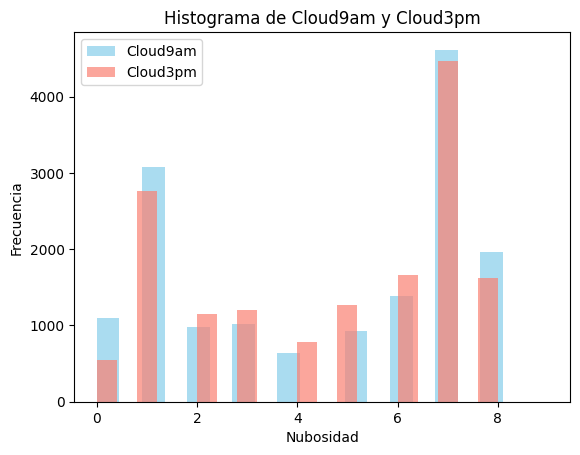

In [148]:
plt.hist(df_train["Cloud9am"], bins=20, color="skyblue", alpha=0.7, label="Cloud9am")
plt.hist(df_train["Cloud3pm"], bins=20, color="salmon", alpha=0.7, label="Cloud3pm")
plt.xlabel("Nubosidad")
plt.ylabel("Frecuencia")
plt.title("Histograma de Cloud9am y Cloud3pm")
plt.legend()
plt.show()

In [149]:
df_train["Cloud9am"] = df_train.groupby(df_train["Date"].dt.day)["Cloud9am"].transform(
    lambda x: x.fillna(x.median())
)
df_train["Cloud3pm"] = df_train.groupby(df_train["Date"].dt.day)["Cloud3pm"].transform(
    lambda x: x.fillna(x.median())
)


df_test["Cloud9am"] = df_test.groupby(df_test["Date"].dt.day)["Cloud9am"].transform(
    lambda x: x.fillna(x.median())
)
df_test["Cloud3pm"] = df_test.groupby(df_test["Date"].dt.day)["Cloud3pm"].transform(
    lambda x: x.fillna(x.median())
)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\3481929352.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Cloud9am"] = df_test.groupby(df_test["Date"].dt.day)["Cloud9am"].transform(
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\3481929352.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Cloud3pm"] = df_test.groupby(df_test["Date"].dt.day)["Cloud3pm"].transform(


Genero una nueva columna llamada 'Dif_Cloud' imputandole el valor correspondiente a la diferencia de las columnas 'Humidity9am' y 'HUmidity3pm' **( 'Cloud9am' - 'Cloud3pm' )**


In [150]:
df_train["Cloud_Difference"] = df_train["Cloud9am"] - df_train["Cloud3pm"]
df_train.drop(["Cloud9am", "Cloud3pm"], axis=1, inplace=True)


df_test["Cloud_Difference"] = df_test["Cloud9am"] - df_test["Cloud3pm"]
df_test.drop(["Cloud9am", "Cloud3pm"], axis=1, inplace=True)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\895804715.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Cloud_Difference"] = df_test["Cloud9am"] - df_test["Cloud3pm"]
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\895804715.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["Cloud9am", "Cloud3pm"], axis=1, inplace=True)


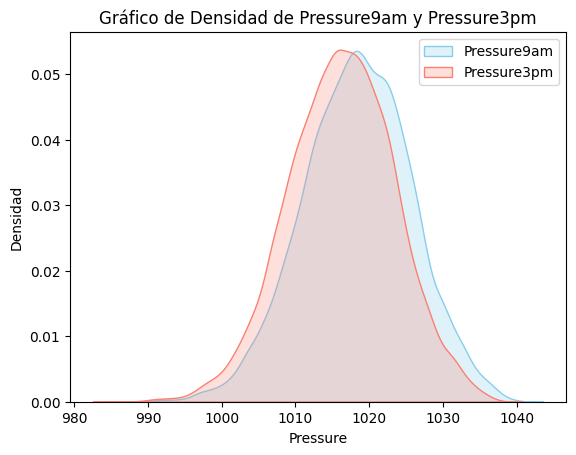

In [151]:
sns.kdeplot(df_train["Pressure9am"], color="skyblue", label="Pressure9am", fill=True)
sns.kdeplot(df_train["Pressure3pm"], color="salmon", label="Pressure3pm", fill=True)
plt.xlabel("Pressure")
plt.ylabel("Densidad")
plt.title("Gráfico de Densidad de Pressure9am y Pressure3pm")
plt.legend()
plt.show()

Observando la distribucion de las variables 'Pressure9am' y 'Pressure3pm' se observa una distribucion normal, por lo que decido imputar los valores nulos utilizando la **Media**.


In [152]:
df_train["Pressure9am"] = df_train.groupby(df_train["Date"].dt.day)[
    "Pressure9am"
].transform(lambda x: x.fillna(x.mean()))
df_train["Pressure3pm"] = df_train.groupby(df_train["Date"].dt.day)[
    "Pressure3pm"
].transform(lambda x: x.fillna(x.mean()))


df_test["Pressure9am"] = df_test.groupby(df_test["Date"].dt.day)[
    "Pressure9am"
].transform(lambda x: x.fillna(x.mean()))
df_test["Pressure3pm"] = df_test.groupby(df_test["Date"].dt.day)[
    "Pressure3pm"
].transform(lambda x: x.fillna(x.mean()))

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2298753384.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Pressure9am"] = df_test.groupby(df_test["Date"].dt.day)[
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2298753384.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Pressure3pm"] = df_test.groupby(df_test["Date"].dt.day)[


Genero una nueva columna llamada 'Dif_Pressure' imputandole el valor correspondiente a la diferencia de las columnas 'Pressure9am' y 'Pressure3pm' **( 'Pressure9am' - 'Pressure3pm' )**


In [153]:
df_train["Pressure_Difference"] = df_train["Pressure9am"] - df_train["Pressure3pm"]
df_train.drop(["Pressure9am", "Pressure3pm"], axis=1, inplace=True)


df_test["Pressure_Difference"] = df_test["Pressure9am"] - df_test["Pressure3pm"]
df_test.drop(["Pressure9am", "Pressure3pm"], axis=1, inplace=True)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2911089513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Pressure_Difference"] = df_test["Pressure9am"] - df_test["Pressure3pm"]
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2911089513.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["Pressure9am", "Pressure3pm"], axis=1, inplace=True)


##### Variables: MaxTemp, MinTemp, Temp9am y Temp3pm


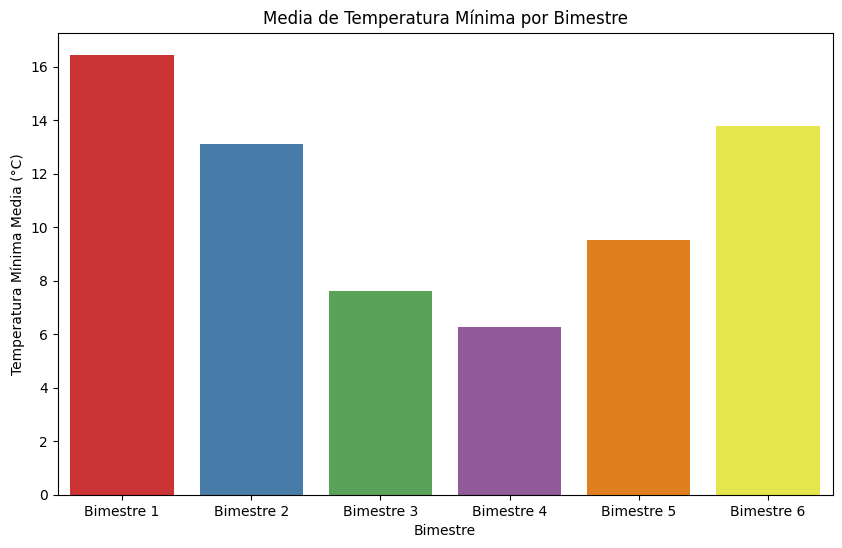

In [154]:
# Calcula la media de temperatura mínima para cada bimestre
mean_temps = df_train.groupby("Bimestre")["MinTemp"].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Bimestre",
    y="MinTemp",
    data=mean_temps,
    hue="Bimestre",
    palette="Set1",
    dodge=False,
    legend=False,
)
plt.title("Media de Temperatura Mínima por Bimestre")
plt.xlabel("Bimestre")
plt.ylabel("Temperatura Mínima Media (°C)")
plt.show()

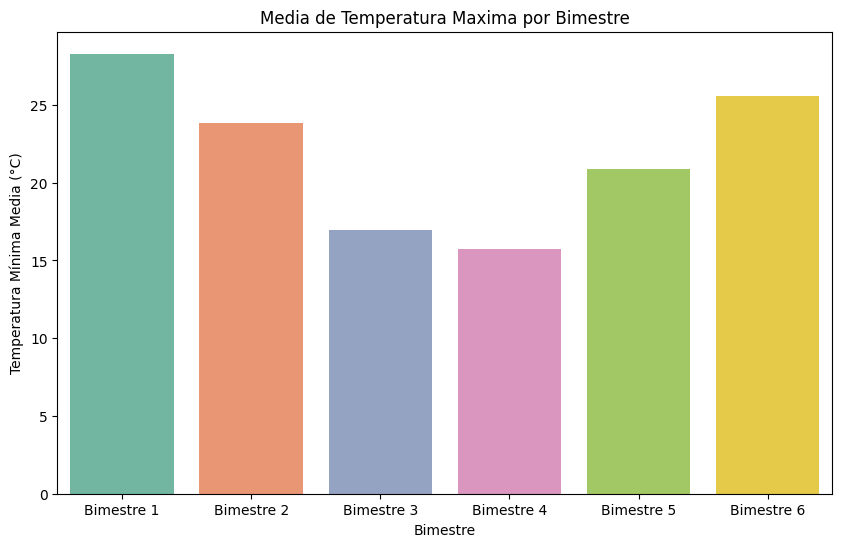

In [155]:
# Calcula la media de temperatura mínima para cada bimestre
mean_temps = df_train.groupby("Bimestre")["MaxTemp"].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Bimestre",
    y="MaxTemp",
    data=mean_temps,
    hue="Bimestre",
    palette="Set2",
    dodge=False,
    legend=False,
)
plt.title("Media de Temperatura Maxima por Bimestre")
plt.xlabel("Bimestre")
plt.ylabel("Temperatura Mínima Media (°C)")
plt.show()

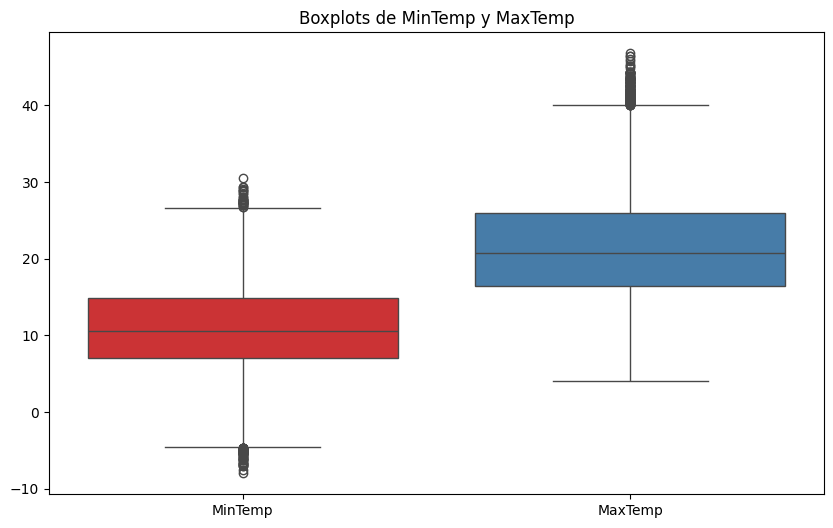

In [156]:
data_to_plot = df_train[["MinTemp", "MaxTemp"]]
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_to_plot, palette="Set1")
plt.title("Boxplots de MinTemp y MaxTemp")
plt.show()

Puedo apreciar variaciones en los valores tanto en la variable MinTemp como MaxTemp dependiendo del bimestre del año, a la vez observo outliers por lo que en este caso decido rellenar los valores nulos con la Mediana del bimestre correspondiente a cada registro.


In [157]:
median_min_temp_by_bimestre_train = df_train.groupby("Bimestre")["MinTemp"].median()

for bimestre, median_temp in median_min_temp_by_bimestre_train.items():
    df_train.loc[df_train["Bimestre"] == bimestre, "MinTemp"] = df_train.loc[
        df_train["Bimestre"] == bimestre, "MinTemp"
    ].fillna(median_temp)

for bimestre, median_temp in median_min_temp_by_bimestre_train.items():
    df_test.loc[df_test["Bimestre"] == bimestre, "MinTemp"] = df_test.loc[
        df_test["Bimestre"] == bimestre, "MinTemp"
    ].fillna(median_temp)


median_max_temp_by_bimestre_train = df_train.groupby("Bimestre")["MaxTemp"].median()

for bimestre, median_temp in median_max_temp_by_bimestre_train.items():
    df_train.loc[df_train["Bimestre"] == bimestre, "MaxTemp"] = df_train.loc[
        df_train["Bimestre"] == bimestre, "MaxTemp"
    ].fillna(median_temp)

for bimestre, median_temp in median_max_temp_by_bimestre_train.items():
    df_test.loc[df_test["Bimestre"] == bimestre, "MaxTemp"] = df_test.loc[
        df_test["Bimestre"] == bimestre, "MaxTemp"
    ].fillna(median_temp)

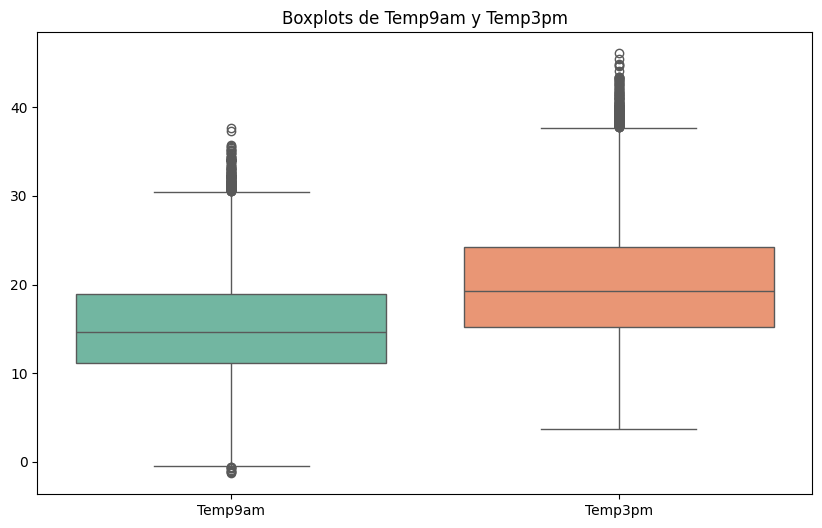

In [158]:
data_to_plot = df_train[["Temp9am", "Temp3pm"]]
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_to_plot, palette="Set2")
plt.title("Boxplots de Temp9am y Temp3pm")
plt.show()

Completo los valores nulos de Temp9am y Temp3pm con la mediana por dia debido a la presencia de outliers.


In [159]:
df_train["Temp9am"] = df_train.groupby(df_train["Date"].dt.day)["Temp9am"].transform(
    lambda x: x.fillna(x.median())
)
df_train["Temp3pm"] = df_train.groupby(df_train["Date"].dt.day)["Temp3pm"].transform(
    lambda x: x.fillna(x.median())
)

df_test["Temp9am"] = df_test.groupby(df_test["Date"].dt.day)["Temp9am"].transform(
    lambda x: x.fillna(x.median())
)
df_test["Temp3pm"] = df_test.groupby(df_test["Date"].dt.day)["Temp3pm"].transform(
    lambda x: x.fillna(x.median())
)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\79697992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Temp9am"] = df_test.groupby(df_test["Date"].dt.day)["Temp9am"].transform(
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\79697992.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Temp3pm"] = df_test.groupby(df_test["Date"].dt.day)["Temp3pm"].transform(


In [160]:
df_train.isna().sum()

Date                      0
MinTemp                   0
MaxTemp                   0
Rainfall                  0
Evaporation               0
Sunshine                  0
WindGustDir               0
WindGustSpeed             0
WindDir9am                0
WindDir3pm                0
Temp9am                   0
Temp3pm                   0
RainToday               162
RainTomorrow              0
RainfallTomorrow          0
Bimestre                  0
WindSpeed_Difference      0
Humidity_Difference       0
Cloud_Difference          0
Pressure_Difference       0
dtype: int64

Genero una nueva columna llamada 'Dif_Temp' imputandole el valor correspondiente a la diferencia de las columnas 'Temp3pm' y 'Temp9am' **( 'Temp3pm' - 'Temp9am' )**


In [161]:
df_train["Temp_Difference"] = df_train["Temp3pm"] - df_train["Temp9am"]
df_train.drop(["Temp3pm", "Temp9am"], axis=1, inplace=True)

df_test["Temp_Difference"] = df_test["Temp3pm"] - df_test["Temp9am"]
df_test.drop(["Temp3pm", "Temp9am"], axis=1, inplace=True)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2225553530.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Temp_Difference"] = df_test["Temp3pm"] - df_test["Temp9am"]
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2225553530.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["Temp3pm", "Temp9am"], axis=1, inplace=True)


Genero una nueva columna llamada 'Dif_Temp_Max_Min' imputandole el valor correspondiente a la diferencia de las columnas 'MaxTemp' y 'MinTemp' **( 'MaxTemp' - 'MinTemp' )**


In [162]:
df_train["Dif_Temp_Max_Min"] = df_train["MaxTemp"] - df_train["MinTemp"]
df_train.drop(["MaxTemp", "MinTemp"], axis=1, inplace=True)

df_test["Dif_Temp_Max_Min"] = df_test["MaxTemp"] - df_test["MinTemp"]
df_test.drop(["MaxTemp", "MinTemp"], axis=1, inplace=True)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2282185811.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Dif_Temp_Max_Min"] = df_test["MaxTemp"] - df_test["MinTemp"]
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2282185811.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["MaxTemp", "MinTemp"], axis=1, inplace=True)


##### Variables: RainToday y RainTomorrow


Relleno los valores nulos de 'RainToday' con la **Moda** por dia.


In [163]:
print(df_train["RainToday"].isna().sum())
print(df_train["RainTomorrow"].isna().sum())
print(df_train["RainfallTomorrow"].isna().sum())

162
0
0


In [164]:
moda_RainToday_train = df_train.groupby("Date")["RainToday"].transform(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)
df_train["RainToday"] = df_train["RainToday"].fillna(moda_RainToday_train)

moda_RainToday_test = df_test.groupby("Date")["RainToday"].transform(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)
df_test["RainToday"] = df_test["RainToday"].fillna(moda_RainToday_test)


moda_RainTomorrow_test = df_test.groupby("Date")["RainTomorrow"].transform(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)
df_test["RainTomorrow"] = df_test["RainTomorrow"].fillna(moda_RainTomorrow_test)

moda_RainfallTomorrow_test = df_test.groupby("Date")["RainfallTomorrow"].transform(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)
df_test["RainfallTomorrow"] = df_test["RainfallTomorrow"].fillna(
    moda_RainfallTomorrow_test
)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2738604382.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["RainToday"] = df_test["RainToday"].fillna(moda_RainToday_test)
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2738604382.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["RainTomorrow"] = df_test["RainTomorrow"].fillna(moda_RainTomorrow_test)
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\2738604382.py:20: SettingWithCopyWarning: 
A value is trying to be set

In [165]:
df_test.isna().sum()

Date                    0
Rainfall                0
Evaporation             0
Sunshine                0
WindGustDir             0
WindGustSpeed           0
WindDir9am              0
WindDir3pm              0
RainToday               0
RainTomorrow            0
RainfallTomorrow        0
Bimestre                0
WindSpeed_Difference    0
Humidity_Difference     0
Cloud_Difference        0
Pressure_Difference     0
Temp_Difference         0
Dif_Temp_Max_Min        0
dtype: int64

In [166]:
print(df_train["RainToday"].isna().sum())
print(df_train["RainTomorrow"].isna().sum())
print(df_train["RainfallTomorrow"].isna().sum())

0
0
0


La columna 'RainToday' y 'RainTomorrow' tienen valores 'Yes' 'No' por lo que los mapeo a 1 para 'Yes' y 0 para 'No'.


In [167]:
df_train["RainToday"] = df_train["RainToday"].map({"Yes": 1, "No": 0})
df_train["RainTomorrow"] = df_train["RainTomorrow"].map({"Yes": 1, "No": 0})


df_test["RainToday"] = df_test["RainToday"].map({"Yes": 1, "No": 0})
df_test["RainTomorrow"] = df_test["RainTomorrow"].map({"Yes": 1, "No": 0})

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\3786583145.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["RainToday"] = df_test["RainToday"].map({"Yes": 1, "No": 0})
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\3786583145.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["RainTomorrow"] = df_test["RainTomorrow"].map({"Yes": 1, "No": 0})


In [168]:
df_train.isna().sum()

Date                    0
Rainfall                0
Evaporation             0
Sunshine                0
WindGustDir             0
WindGustSpeed           0
WindDir9am              0
WindDir3pm              0
RainToday               0
RainTomorrow            0
RainfallTomorrow        0
Bimestre                0
WindSpeed_Difference    0
Humidity_Difference     0
Cloud_Difference        0
Pressure_Difference     0
Temp_Difference         0
Dif_Temp_Max_Min        0
dtype: int64

### Dummies


In [169]:
df_train["WindGustDir"].unique()

array(['SSW', 'S', 'SE', 'NNE', 'WNW', 'N', 'ENE', 'NE', 'E', 'SW', 'W',
       'WSW', 'NNW', 'ESE', 'SSE', 'NW'], dtype=object)

In [170]:
orien = [
    "SSW",
    "S",
    "SE",
    "NNE",
    "WNW",
    "N",
    "ENE",
    "NE",
    "E",
    "SW",
    "W",
    "WSW",
    "NNW",
    "ESE",
    "SSE",
    "NW",
]
print(len(orien))

16


Agrupo los valores de la variables categoricas de Direccion, que tiene los siguientes valores:

['SSW', 'S', 'SE', 'NNE', 'WNW', 'N', 'ENE', 'NE', 'E', 'SW', 'W', 'WSW', 'NNW', 'ESE', 'SSE', 'NW']

El criterio que empleo es asignar a cada punto cardenal el predominante, por ejemplo 'NNW' lo asigno a 'N'

Para los valores como, por ejemplo 'NE' o 'SW' los asigno al ultimo punto cardinal de la notacion.


In [171]:
def agrupar_direcciones(direccion):
    grupos_principales = {
        "N": ["N", "NNW", "NNE"],
        "S": ["S", "SSW", "SSE"],
        "E": ["E", "ENE", "ESE", "SE", "NE"],
        "W": ["W", "WNW", "WSW", "SW", "NW"],
    }

    for grupo, direcciones in grupos_principales.items():
        if direccion in direcciones:
            return grupo

    return "Otro"

In [172]:
df_train["WindGustDir_Agrupado"] = df_train["WindGustDir"].apply(agrupar_direcciones)
df_train["WindDir9am_Agrupado"] = df_train["WindDir9am"].apply(agrupar_direcciones)
df_train["WindDir3pm_Agrupado"] = df_train["WindDir3pm"].apply(agrupar_direcciones)

df_test["WindGustDir_Agrupado"] = df_test["WindGustDir"].apply(agrupar_direcciones)
df_test["WindDir9am_Agrupado"] = df_test["WindDir9am"].apply(agrupar_direcciones)
df_test["WindDir3pm_Agrupado"] = df_test["WindDir3pm"].apply(agrupar_direcciones)


df_train = df_train.drop("WindGustDir", axis=1)
df_train = df_train.drop("WindDir9am", axis=1)
df_train = df_train.drop("WindDir3pm", axis=1)

df_test = df_test.drop("WindGustDir", axis=1)
df_test = df_test.drop("WindDir9am", axis=1)
df_test = df_test.drop("WindDir3pm", axis=1)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\1341930653.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindGustDir_Agrupado"] = df_test["WindGustDir"].apply(agrupar_direcciones)
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\1341930653.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindDir9am_Agrupado"] = df_test["WindDir9am"].apply(agrupar_direcciones)
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\1341930653.py:7: SettingWithCopyWarning: 
A value is tryin

##### Dummies WindGustDir


In [173]:
d_WindGustDir_train = pd.get_dummies(
    df_train["WindGustDir_Agrupado"], dtype=int, drop_first=True
)

d_WindGustDir_train = d_WindGustDir_train.rename(
    columns={"N": "WindGustDir_N", "S": "WindGustDir_S", "W": "WindGustDir_W"}
)
df_train = df_train.drop("WindGustDir_Agrupado", axis=1)
df_train = pd.concat([df_train, d_WindGustDir_train], axis=1)


d_WindGustDir_test = pd.get_dummies(
    df_test["WindGustDir_Agrupado"], dtype=int, drop_first=True
)

d_WindGustDir_test = d_WindGustDir_test.rename(
    columns={"N": "WindGustDir_N", "S": "WindGustDir_S", "W": "WindGustDir_W"}
)
df_test = df_test.drop("WindGustDir_Agrupado", axis=1)
df_test = pd.concat([df_test, d_WindGustDir_test], axis=1)

##### Dummies WindDir9am


In [174]:
d_WindDir9am_train = pd.get_dummies(
    df_train["WindDir9am_Agrupado"], dtype=int, drop_first=True
)
d_WindDir9am_train = d_WindDir9am_train.rename(
    columns={"N": "WindDir9am_N", "S": "WindDir9am_S", "W": "WindDir9am_W"}
)
df_train = df_train.drop("WindDir9am_Agrupado", axis=1)
df_train = pd.concat([df_train, d_WindDir9am_train], axis=1)


d_WindDir9am_test = pd.get_dummies(
    df_test["WindDir9am_Agrupado"], dtype=int, drop_first=True
)
d_WindDir9am_test = d_WindDir9am_test.rename(
    columns={"N": "WindDir9am_N", "S": "WindDir9am_S", "W": "WindDir9am_W"}
)
df_test = df_test.drop("WindDir9am_Agrupado", axis=1)
df_test = pd.concat([df_test, d_WindDir9am_test], axis=1)

##### Dummies WindDir3pm


In [175]:
d_WindDir3pm_train = pd.get_dummies(
    df_train["WindDir3pm_Agrupado"], dtype=int, drop_first=True
)
d_WindDir3pm_train = d_WindDir3pm_train.rename(
    columns={"N": "WindDir3pm_N", "S": "WindDir3pm_S", "W": "WindDir3pm_W"}
)
df_train = df_train.drop("WindDir3pm_Agrupado", axis=1)
df_train = pd.concat([df_train, d_WindDir3pm_train], axis=1)


d_WindDir3pm_test = pd.get_dummies(
    df_test["WindDir3pm_Agrupado"], dtype=int, drop_first=True
)
d_WindDir3pm_test = d_WindDir3pm_test.rename(
    columns={"N": "WindDir3pm_N", "S": "WindDir3pm_S", "W": "WindDir3pm_W"}
)
df_test = df_test.drop("WindDir3pm_Agrupado", axis=1)
df_test = pd.concat([df_test, d_WindDir3pm_test], axis=1)

In [176]:
df_train.drop("Bimestre", axis=1, inplace=True)
df_train.drop("Date", axis=1, inplace=True)

df_test.drop("Bimestre", axis=1, inplace=True)
df_test.drop("Date", axis=1, inplace=True)

In [177]:
columnas = df_train.columns
print(columnas)
print(len(columnas))

Index(['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'RainToday',
       'RainTomorrow', 'RainfallTomorrow', 'WindSpeed_Difference',
       'Humidity_Difference', 'Cloud_Difference', 'Pressure_Difference',
       'Temp_Difference', 'Dif_Temp_Max_Min', 'WindGustDir_N', 'WindGustDir_S',
       'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W',
       'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W'],
      dtype='object')
22


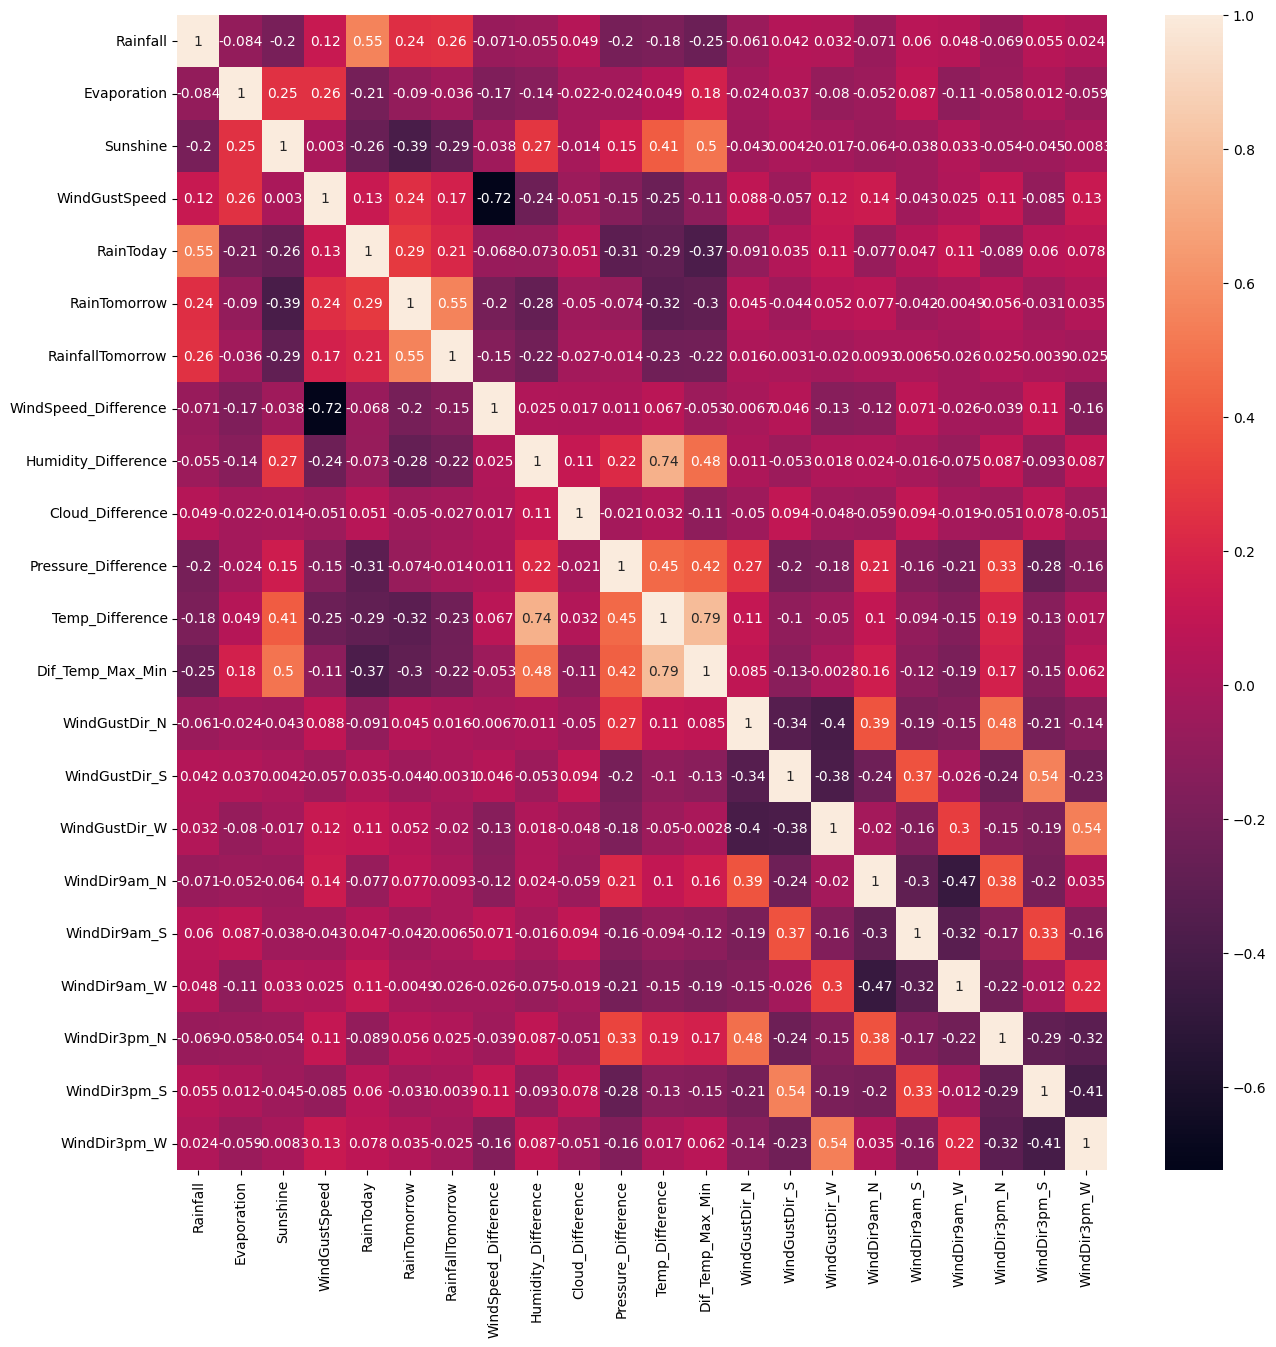

In [178]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    df_train.corr(),
    annot=True,
)
plt.show()

In [179]:
df_train.isna().sum()

Rainfall                0
Evaporation             0
Sunshine                0
WindGustSpeed           0
RainToday               0
RainTomorrow            0
RainfallTomorrow        0
WindSpeed_Difference    0
Humidity_Difference     0
Cloud_Difference        0
Pressure_Difference     0
Temp_Difference         0
Dif_Temp_Max_Min        0
WindGustDir_N           0
WindGustDir_S           0
WindGustDir_W           0
WindDir9am_N            0
WindDir9am_S            0
WindDir9am_W            0
WindDir3pm_N            0
WindDir3pm_S            0
WindDir3pm_W            0
dtype: int64

# Estandarizacion de datos


In [180]:
# df_train
scaler = StandardScaler()
df_train_estandarizado = scaler.fit_transform(df_train)
df_train_estandarizado = pd.DataFrame(df_train_estandarizado, columns=df_train.columns)

# df_test
scaler = StandardScaler()
df_test_estandarizado = scaler.fit_transform(df_test)
df_test_estandarizado = pd.DataFrame(df_test_estandarizado, columns=df_test.columns)

# Regularizacion de datos

In [181]:
# X, y TRAIN
X_train = df_train_estandarizado[
    [
        "Rainfall",
        "Evaporation",
        "Sunshine",
        "WindGustSpeed",
        "RainToday",
        "WindSpeed_Difference",
        "Humidity_Difference",
        "Cloud_Difference",
        "Pressure_Difference",
        "Temp_Difference",
        "Dif_Temp_Max_Min",
        "WindGustDir_N",
        "WindGustDir_S",
        "WindGustDir_W",
        "WindDir9am_N",
        "WindDir9am_S",
        "WindDir9am_W",
        "WindDir3pm_N",
        "WindDir3pm_S",
        "WindDir3pm_W",
    ]
]
y_train = df_train_estandarizado["RainfallTomorrow"]

# X, y TEST

X_test = df_test_estandarizado[
    [
        "Rainfall",
        "Evaporation",
        "Sunshine",
        "WindGustSpeed",
        "RainToday",
        "WindSpeed_Difference",
        "Humidity_Difference",
        "Cloud_Difference",
        "Pressure_Difference",
        "Temp_Difference",
        "Dif_Temp_Max_Min",
        "WindGustDir_N",
        "WindGustDir_S",
        "WindGustDir_W",
        "WindDir9am_N",
        "WindDir9am_S",
        "WindDir9am_W",
        "WindDir3pm_N",
        "WindDir3pm_S",
        "WindDir3pm_W",
    ]
]
y_test = df_test_estandarizado["RainfallTomorrow"]

# Lasso


In [182]:
lasso = Lasso(alpha=0.1)  # alpha controla la fuerza de la regularización L1 (Lasso)

lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [183]:
print("\nCoeficientes del modelo Lasso:")
print(lasso.coef_)
print("Lasso Score df_train:", lasso.score(X_test, y_test))
print("Lasso Score df_test:", lasso.score(X_test, y_test))


Coeficientes del modelo Lasso:
[ 0.12155352 -0.         -0.14470672  0.0267217   0.         -0.02120144
 -0.06935442 -0.          0.         -0.         -0.          0.
 -0.         -0.          0.         -0.         -0.          0.
 -0.         -0.        ]
Lasso Score df_train: 0.14654024119204834
Lasso Score df_test: 0.14654024119204834


# Ridge


In [184]:
ridge = Ridge(alpha=0.1)  # alpha controla la fuerza de la regularización L2 (Ridge)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [185]:
print("\nCoeficientes del modelo Ridge:")
print(ridge.coef_)
print("Ridge Score df_train:", ridge.score(X_train, y_train))
print("Ridge Score df_test:", ridge.score(X_test, y_test))


Coeficientes del modelo Ridge:
[ 1.75968157e-01 -1.24942065e-02 -1.99415271e-01  6.50731336e-02
  6.60069486e-02 -1.02075134e-01 -1.48319483e-01 -2.51094507e-02
  1.18746700e-01  3.95649491e-03 -4.00455175e-02 -2.45407615e-02
 -1.40753788e-02 -3.53362922e-02 -6.42340759e-02 -3.61290250e-02
 -6.94630699e-02  3.64895191e-03 -7.07418667e-05 -2.75092585e-03]
Ridge Score df_train: 0.18470594149224606
Ridge Score df_test: 0.22007724001509776


# Elasticnet

In [186]:
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.1)

In [187]:
print("\nCoeficientes del modelo ElasticNet:")
print(elasticnet.coef_)
print("Elasticnet Score df_train:", elasticnet.score(X_train, y_train))
print("Elasticnet Score df_test:", elasticnet.score(X_test, y_test))



Coeficientes del modelo ElasticNet:
[ 0.14280522 -0.         -0.16963472  0.03753369  0.02963833 -0.05729339
 -0.10652422 -0.          0.02775225 -0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.        ]
Elasticnet Score df_train: 0.16196787179885241
Elasticnet Score df_test: 0.18070502094672858


# Regresion Lineal


Para evitar una Fuga de Datos voy a eliminar de mi dataset las variables RainTomorrow y RainfallTomorrow.


In [188]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# MSE: Error Cuadratico Medio
mse = mean_squared_error(y_test, y_pred)

# R^2
r2 = r2_score(y_test, y_pred)

# MAE: Error Absoluto Medio
mae = mean_absolute_error(y_test, y_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nR^2: {r2}\n")
print(f"MSE(Error Cuadratico Medio): {mse}\n")
print(f"MAE(Error Absoluto Medio): {mae}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse}\n")

Coefficients: [ 1.75969041e-01 -1.24944318e-02 -1.99416279e-01  6.50731350e-02
  6.60068958e-02 -1.02075948e-01 -1.48321506e-01 -2.51095737e-02
  1.18747401e-01  3.95887791e-03 -4.00463368e-02 -2.45411749e-02
 -1.40756628e-02 -3.53366647e-02 -6.42354004e-02 -3.61298515e-02
 -6.94642199e-02  3.64905129e-03 -7.02691515e-05 -2.75033798e-03]
Intercept: 7.685680620018716e-17

R^2: 0.2200774002512378

MSE(Error Cuadratico Medio): 0.7799225997487622

MAE(Error Absoluto Medio): 0.4314647197286559

RMSE(Raíz del Error Cuadrático Medio): 0.8831322662822156



#### Optimizacion de Hiperparametros

In [189]:
from sklearn.model_selection import GridSearchCV

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'fit_intercept': [False, True],
    'copy_X': [True, False]
}
# Inicializar la búsqueda en cuadrícula
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train, y_train)
# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'copy_X': True, 'fit_intercept': False}


In [190]:
model2 = LinearRegression(copy_X=True, fit_intercept=False)

model2.fit(X_train, y_train)

y_predopt = model2.predict(X_test)

coefficientsopt = model2.coef_
interceptopt = model2.intercept_
print("Coefficients:", coefficientsopt)
print("Intercept:", interceptopt)

# MSE: Error Cuadratico Medio
mseopt = mean_squared_error(y_test, y_predopt)

# R^2
r2opt= r2_score(y_test, y_predopt)

# MAE: Error Absoluto Medio
maeopt = mean_absolute_error(y_test, y_predopt)

# RMSE: Raíz del Error Cuadrático Medio
rmseopt = np.sqrt(mean_squared_error(y_test, y_predopt))

print(f"\nR^2: {r2opt}\n")
print(f"MSE(Error Cuadratico Medio): {mseopt}\n")
print(f"MAE(Error Absoluto Medio): {maeopt}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmseopt}\n")

Coefficients: [ 1.75969041e-01 -1.24944318e-02 -1.99416279e-01  6.50731350e-02
  6.60068958e-02 -1.02075948e-01 -1.48321506e-01 -2.51095737e-02
  1.18747401e-01  3.95887791e-03 -4.00463368e-02 -2.45411749e-02
 -1.40756628e-02 -3.53366647e-02 -6.42354004e-02 -3.61298515e-02
 -6.94642199e-02  3.64905129e-03 -7.02691515e-05 -2.75033798e-03]
Intercept: 0.0

R^2: 0.2200774002512378

MSE(Error Cuadratico Medio): 0.7799225997487622

MAE(Error Absoluto Medio): 0.43146471972865585

RMSE(Raíz del Error Cuadrático Medio): 0.8831322662822156



Con la optimizacion de hiperparametros no aprecio variaciones en las metricas.

## Gradiente descendiente

Probe usar el metodo de clase pero no pude correrlo debido a que me presentaba un error y no supe como solucionarlo.

Por otro lado, busque en internet como hacerlo usando la ScikitLearn y lo implemente.

In [191]:
# Regresión lineal utilizando SGDRegressor
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)

model_sgd.fit(X_train, y_train)

y_pred_sgd = model_sgd.predict(X_test)

# Coeficientes
coefficients_sgd = model_sgd.coef_
intercept_sgd = model_sgd.intercept_
print("Coefficients (SGD):", coefficients_sgd)
print("Intercept (SGD):", intercept_sgd)

# MSE: Error Cuadrático Medio
mse_sgd = mean_squared_error(y_test, y_pred_sgd)

# R^2
r2_sgd = r2_score(y_test, y_pred_sgd)

# MAE: Error Absoluto Medio
mae_sgd = mean_absolute_error(y_test, y_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_sgd = np.sqrt(mse_sgd)

print(f"\nR^2 (SGD): {r2_sgd}\n")
print(f"MSE (SGD): {mse_sgd}\n")
print(f"MAE (SGD): {mae_sgd}\n")
print(f"RMSE (SGD): {rmse_sgd}\n")

Coefficients (SGD): [ 0.22193934 -0.03154869 -0.21539235  0.07452066  0.08307172 -0.10476956
 -0.15490735 -0.00677138  0.14118146  0.00142175 -0.04150308 -0.02023513
 -0.01017567 -0.03882054 -0.05245664 -0.04082976 -0.07448872 -0.00028771
 -0.0125832  -0.00400644]
Intercept (SGD): [0.01468528]

R^2 (SGD): 0.21901789114807757

MSE (SGD): 0.7809821088519224

MAE (SGD): 0.44608245930576973

RMSE (SGD): 0.8837319213720428



In [192]:
y_train_gd = y_train.values.reshape(-1, 1)
y_test_gd = y_test.values.reshape(-1, 1)

In [193]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

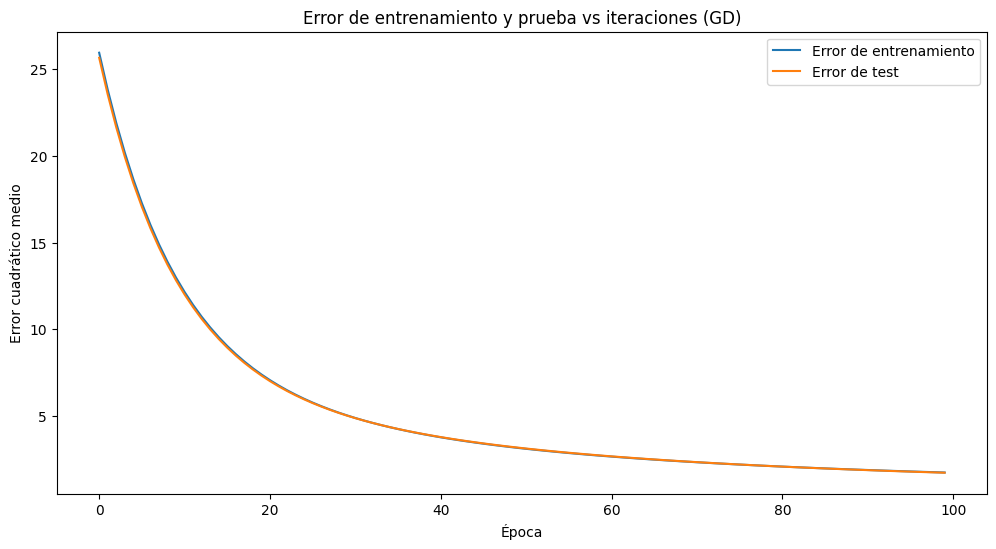

array([[-0.1226466 ],
       [ 0.35034063],
       [-0.34168975],
       [ 0.07088561],
       [-0.12971405],
       [-0.00919184],
       [-0.11963745],
       [-0.85654171],
       [ 0.23016516],
       [-0.30667549],
       [ 0.15595534],
       [ 0.34915827],
       [ 0.36727912],
       [ 0.79496499],
       [ 0.53862786],
       [-0.46597997],
       [-0.29059049],
       [-0.49668671],
       [ 0.10966801],
       [-0.70193174],
       [-0.26400886]])

In [194]:
gradient_descent(X_train, y_train_gd, X_test, y_test_gd, lr=0.01, epochs=100)

In [195]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

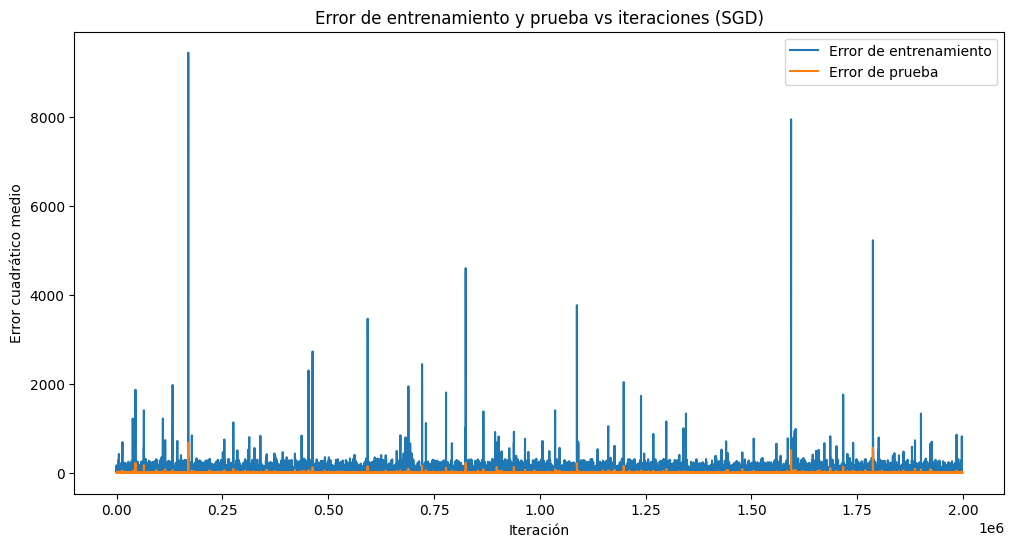

array([[ 0.1890776 ],
       [ 0.13839953],
       [ 0.1285379 ],
       [-0.40655752],
       [ 0.19579669],
       [ 0.25395341],
       [-0.40468852],
       [-0.31444827],
       [-0.04209916],
       [ 0.2349544 ],
       [-0.12060375],
       [-0.03466127],
       [ 0.2373853 ],
       [-0.02834003],
       [ 0.06123264],
       [ 0.15868781],
       [-0.21064706],
       [-0.04810143],
       [ 0.15620155],
       [-0.12644505],
       [-0.16468865]])

In [196]:
stochastic_gradient_descent(X_train, y_train_gd, X_test, y_test_gd, lr=0.01, epochs=100)

In [197]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

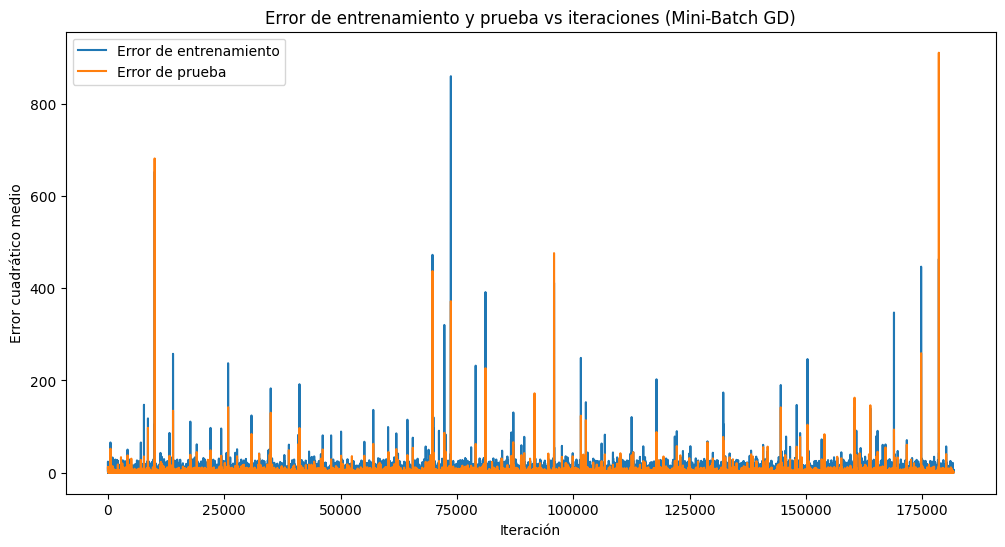

array([[-0.0190359 ],
       [ 0.11868866],
       [-0.03123884],
       [-0.30496317],
       [ 0.09140512],
       [-0.06583922],
       [-0.02681205],
       [-0.14833078],
       [-0.08662007],
       [ 0.05256964],
       [ 0.18426066],
       [-0.01661802],
       [-0.12747886],
       [ 0.17308945],
       [-0.0173815 ],
       [-0.0839824 ],
       [-0.04969559],
       [-0.03866512],
       [-0.00850508],
       [-0.0216916 ],
       [ 0.01282201]])

In [198]:
mini_batch_gradient_descent(X_train, y_train_gd, X_test, y_test_gd, lr=0.1, epochs=100, batch_size=11)

# Regresion Logistica

In [199]:
# y_train y y_test para la variale RainTomorrow
y_train_rl = df_train["RainTomorrow"]
y_test_rl = df_test["RainTomorrow"]

### Conjunto de entrenamiento

In [200]:
logistic_model = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model.fit(X_train, y_train_rl)
y_pred_train_rl = logistic_model.predict(X_train)
y_pred_test_rl = logistic_model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_train_rl, y_pred_train_rl)

Métricas para logreg:
Accuracy balanceado: 0.7584233492715498
Matriz de confusión:
[[11673  3569]
 [ 1180  3559]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83     15242
           1       0.50      0.75      0.60      4739

    accuracy                           0.76     19981
   macro avg       0.70      0.76      0.72     19981
weighted avg       0.81      0.76      0.78     19981



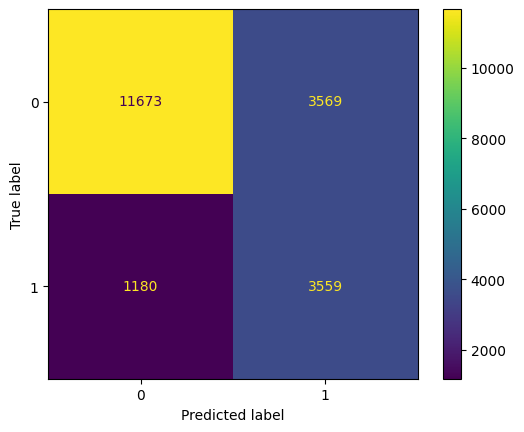

In [201]:
# Calcular métricas
balanced_accuracy = balanced_accuracy_score(y_train_rl, y_pred_train_rl)
# accuracy_logreg = accuracy_score(y_train_rl, y_pred_train_rl)
confusion_matrix_logreg = confusion_matrix(y_train_rl, y_pred_train_rl)
classification_report_logreg = classification_report(y_train_rl, y_pred_train_rl)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Accuracy balanceado: {balanced_accuracy}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_logreg)
disp.plot()
plt.show()

En este caso de aplicacion, el interes se encuentra puesto en predecir si llovera o no, por lo que nos importa principalmente el caso donde se de un **verdadero positivo**, el modelo obtuvo sobre el **conjunto de entrenamiento** un total de 3559 casos en los que predijo que lloveria y llovio, por otra parte hay un total de 3569 casos de **falsos positivos**, predijo que lloveria y no llovio.

Observando la metrica **F1 Score** para los casos **positivos** es de 0.60, por lo que el modelo no es muy eficiente a la hora de predecir esta clase, mientras que para los casos **negativos** obtiene una metrica de 0.83 indicando que tiene mas facilidad para predecir dicha clase, esto puede que tenga que ver con el desbalanceo de clases que hay en el conjunto de datos, hay una mayor presencia de clases negativas que positivas, lo que tiene sentido con la realidad, debido a que generalmente son mas los dias en los que no llueve que los que si.

### Conjunto de test

Métricas para logreg:
Accuracy balanceado: 0.7481981647151785
Matriz de confusión:
[[2549  722]
 [ 299  758]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      3271
           1       0.51      0.72      0.60      1057

    accuracy                           0.76      4328
   macro avg       0.70      0.75      0.72      4328
weighted avg       0.80      0.76      0.78      4328



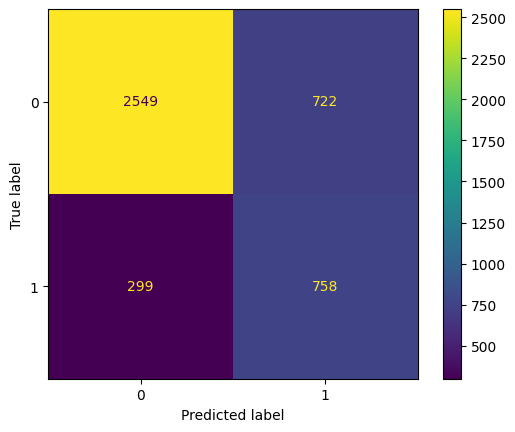

In [202]:
# Calcular métricas
balanced_accuracy = balanced_accuracy_score(y_test_rl, y_pred_test_rl)
# accuracy_logreg = accuracy_score(y_train_rl, y_pred_train_rl)
confusion_matrix_logreg = confusion_matrix(y_test_rl, y_pred_test_rl)
classification_report_logreg = classification_report(y_test_rl, y_pred_test_rl)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Accuracy balanceado: {balanced_accuracy}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_logreg)
disp.plot()
plt.show()

Para el **conjunto de test** vemos tambien valores muy parejos entre los **verdaderos positivos** y **falsos positivos** y obtuvimos los mismos valores que en el conjunto de entrenamiento en la metrica **F1 Score** para ambas clases.

### Curva ROC

In [203]:
# Obtengo las probabilidades de predicción del modelo para los datos de entrenamiento y prueba
y_probs_train = logistic_model.predict_proba(X_train)[:, 1]
y_probs_test = logistic_model.predict_proba(X_test)[:, 1]

# Calculo la ROC y el AUC para los datos de entrenamiento y prueba
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_rl, y_probs_train, pos_label= 1)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test_rl, y_probs_test, pos_label= 1)
roc_auc_test = auc(fpr_test, tpr_test)

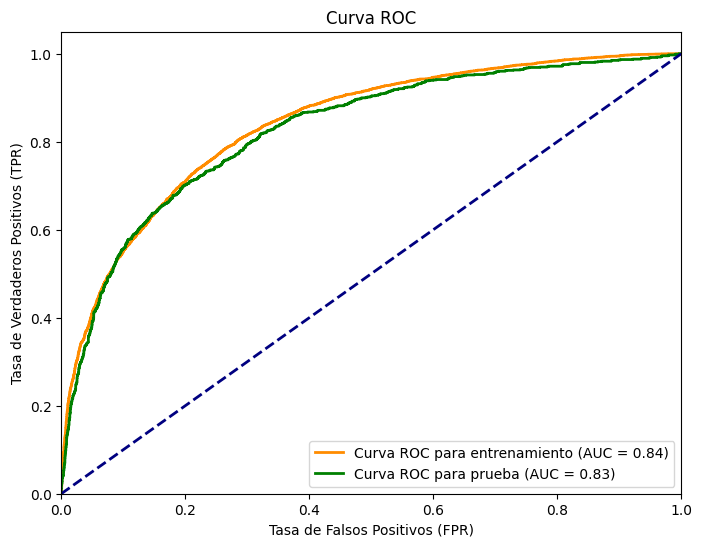

El área bajo la curva para entrenamiento es de: 0.8390292380487396
El área bajo la curva para prueba es de: 0.8265248896078523


In [204]:
# Grafico la curva ROC para los datos de entrenamiento y prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Curva ROC para entrenamiento (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Curva ROC para prueba (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print(f"El área bajo la curva para entrenamiento es de: {roc_auc_train}")
print(f"El área bajo la curva para prueba es de: {roc_auc_test}")

In [205]:
# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de entrenamiento
distances_train = np.sqrt((1 - tpr_train)**2 + fpr_train**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de entrenamiento
min_index_train = np.argmin(distances_train)

# Obtiene el umbral óptimo para los datos de entrenamiento
optimal_threshold_train = thresholds_train[min_index_train]

# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de prueba
distances_test = np.sqrt((1 - tpr_test)**2 + fpr_test**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de prueba
min_index_test = np.argmin(distances_test)

# Obtiene el umbral óptimo para los datos de prueba
optimal_threshold_test = thresholds_test[min_index_test]

print("Umbral óptimo para entrenamiento:", optimal_threshold_train)
print("Umbral óptimo para prueba:", optimal_threshold_test)

Umbral óptimo para entrenamiento: 0.46490806562869885
Umbral óptimo para prueba: 0.4838547307185473


Optimizacion de hiperparametros para la **Regresion Logistica**

In [207]:
from sklearn.model_selection import GridSearchCV

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'penalty': [None, 'l1', 'l2'],
    'dual': [True, False],
    'C': [1, 1.5, 2, 2.5, 3],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced', {0: 0.5, 1: 0.5}]
}

# Definir la cuadrícula de hiperparámetros a explorar
param_grid_2 = {
    'penalty': ['l1', 'l2'],  # Penalidades válidas
    'C': [0.1, 1, 10],  # Fuerza de regularización
    'class_weight': [None, 'balanced'],  # Pesos de clase
    'solver': ['liblinear', 'saga']  # Solver para optimización
}


# Inicializar la búsqueda en cuadrícula
grid_search = GridSearchCV(logreg, param_grid_2, cv=5)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train, y_train_lg)

NameError: name 'logreg' is not defined

In [208]:
# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'copy_X': True, 'fit_intercept': False}


In [209]:
logreg_opt = LogisticRegression(C=0.1, class_weight=None, penalty='l2', solver='saga')

In [210]:
# Entrenar un modelo de regresión logística
logreg_opt.fit(X_train, y_train_lg)

# Realizar predicciones en el conjunto de prueba
y_pred_opt = logreg_opt.predict(X_test)

NameError: name 'y_train_lg' is not defined

Métricas para logreg_opt:
Precisión: 0.8170055452865065
Matriz de confusión:
[[3088  183]
 [ 609  448]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3271
           1       0.71      0.42      0.53      1057

    accuracy                           0.82      4328
   macro avg       0.77      0.68      0.71      4328
weighted avg       0.80      0.82      0.80      4328



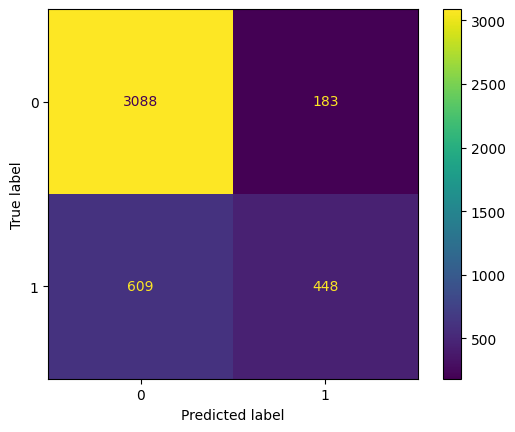

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calcular métricas
accuracy_logreg = accuracy_score(y_test_lg, y_pred_opt)
# accuracy_logreg_2D = accuracy_score(y_test_2D, y_pred_2D)

confusion_matrix_logreg = confusion_matrix(y_test_lg, y_pred_opt)
# confusion_matrix_logreg_2D = confusion_matrix(y_test_2D, y_pred_2D)

classification_report_logreg = classification_report(y_test_lg, y_pred_opt)
# classification_report_logreg_2D = classification_report(y_test_2D, y_pred_2D)

# Imprimir métricas
print("Métricas para logreg_opt:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_logreg)
disp.plot()
plt.show()

En este caso al usar GridSearch para optimizar hiperparametros no se observan cambios en las metricas, con respecto al modelo base.

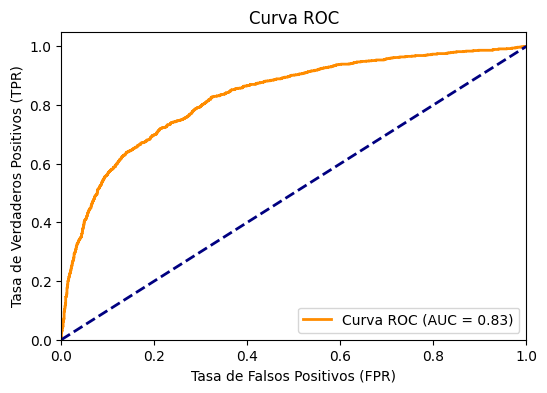

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn import metrics
y_probs_opt = logreg_opt.predict_proba(X_test)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test_lg, y_probs_opt)
roc_auc = auc(fpr, tpr)

# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Balanceo de clases con SMOTE

In [ ]:
# Aplica SMOTE para balancear las clases
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train_lg)
grid_search.fit(X_resampled, y_resampled)
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
logreg_opt.fit(X_resampled, y_resampled)
# Realizar predicciones en el conjunto de prueba
y_pred_opt_smote = logreg_opt.predict(X_test)

Métricas para logreg_opt:
Precisión: 0.7647874306839186
Matriz de confusión:
[[2556  715]
 [ 303  754]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      3271
           1       0.51      0.71      0.60      1057

    accuracy                           0.76      4328
   macro avg       0.70      0.75      0.72      4328
weighted avg       0.80      0.76      0.78      4328



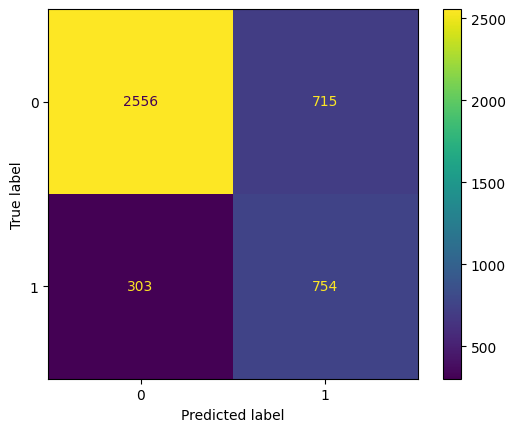

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calcular métricas
accuracy_logreg = accuracy_score(y_test_lg, y_pred_opt_smote)
# accuracy_logreg_2D = accuracy_score(y_test_2D, y_pred_2D)

confusion_matrix_logreg = confusion_matrix(y_test_lg, y_pred_opt_smote)
# confusion_matrix_logreg_2D = confusion_matrix(y_test_2D, y_pred_2D)

classification_report_logreg = classification_report(y_test_lg, y_pred_opt_smote)
# classification_report_logreg_2D = classification_report(y_test_2D, y_pred_2D)

# Imprimir métricas
print("Métricas para logreg_opt:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_logreg)
disp.plot()
plt.show()

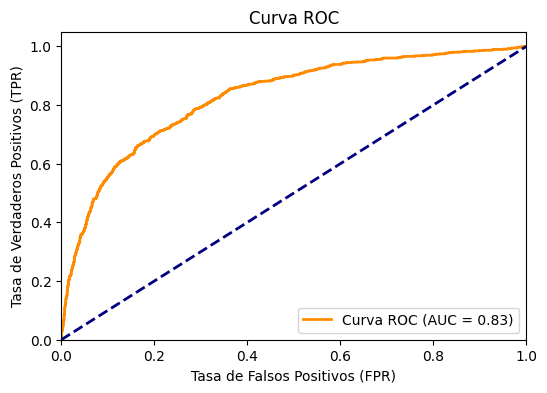

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn import metrics
y_pred_opt_smote = logreg_opt.predict_proba(X_test)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test_lg, y_pred_opt_smote)
roc_auc = auc(fpr, tpr)

# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier

In [ ]:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train_lg)

In [ ]:
len(y_resampled[y_resampled==1]), len(y_resampled[y_resampled==0])

(15242, 15242)

In [ ]:
logreg.fit(X_resampled, y_resampled)
y_pred = logreg.predict(X_test)

print("Resultados regresión logística con Oversampling:\n")
print(classification_report(y_test_lg, y_pred))
print(confusion_matrix(y_test_lg, y_pred))

Resultados regresión logística con Oversampling:

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      3271
           1       0.52      0.72      0.60      1057

    accuracy                           0.77      4328
   macro avg       0.71      0.75      0.72      4328
weighted avg       0.80      0.77      0.78      4328

[[2559  712]
 [ 298  759]]


In [ ]:
# Obtengo las probabilidades de predicción del modelo
y_probs = logreg.predict_proba(X_test)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test_lg, y_probs)
roc_auc = auc(fpr, tpr)

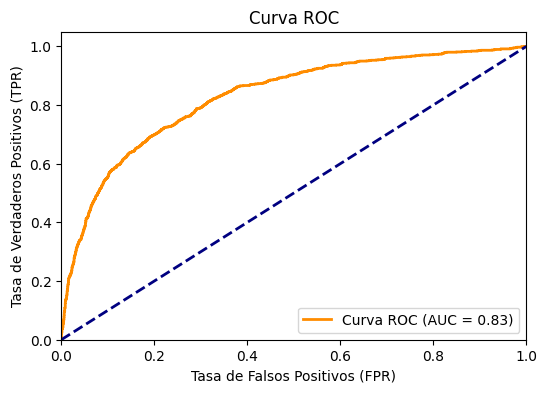

In [ ]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Ejercicio 6 - Modelos Base

### Modelo Base de Regresion

In [211]:
X_train_rl = X_train[["Rainfall", "RainToday"]]
X_test_rl = X_test[["Rainfall", "RainToday"]]

In [212]:
model_rl = LinearRegression()

model_rl.fit(X_train_rl, y_train)

y_pred = model_rl.predict(X_test_rl)

coefficients = model_rl.coef_
intercept = model_rl.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# MSE: Error Cuadratico Medio
mse = mean_squared_error(y_test, y_pred)
# R^2
r2 = r2_score(y_test, y_pred)
# MAE: Error Absoluto Medio
mae = mean_absolute_error(y_test, y_pred)
# RMSE: Raíz del Error Cuadrático Medio
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nR^2: {r2}\n")
print(f"MSE(Error Cuadratico Medio): {mse}\n")
print(f"MAE(Error Absoluto Medio): {mae}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse}\n")

Coefficients: [0.20412472 0.0991735 ]
Intercept: 2.8580622327598343e-17

R^2: 0.08842134639598054

MSE(Error Cuadratico Medio): 0.9115786536040195

MAE(Error Absoluto Medio): 0.4454345377721649

RMSE(Raíz del Error Cuadrático Medio): 0.9547662821884838



El coeficiente **R²** es de 0.084 lo que indica que el modelo no tiene una gran capacidad para explicar la variabilidad de los datos. El modelo no captura adecuadamente las relaciones entre las variables predictoras y la variable objetivo.

El **MSE** con un valor de 0.9116 nos demuestra que las predicciones del modelo estan bastate dispersas respecto a los valores observados, se puede decir que su ajuste es bastante malo.

**Conclusion**: Las metricas obtenidas nos sugieren que las predicciones del modelo no son precisas y tienen un error significativo. Esto podría ser porque el modelo es demasiado simple.

### Modelo Base de Clasificacion

In [213]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [214]:
dummy_random = DummyClassifier(strategy='uniform')
dummy_random.fit(X_train_rl, y_train_rl)
y_pred_random = dummy_random.predict(X_test_rl)

accuracy_random = accuracy_score(y_test_rl, y_pred_random)
print("Accuracy del clasificador aleatorio:", accuracy_random)


Accuracy del clasificador aleatorio: 0.5138632162661737


# Ejercicio 7

### Validacion Cruzada K-Folds

In [215]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier

In [216]:
clf = RandomForestClassifier(n_estimators=50, random_state=42)

In [217]:
X_train_k, x_val_k, y_train_k, y_val_k = train_test_split(X_train_rl, y_train_rl, test_size=0.2, random_state=42)

In [218]:
X_train_k

,Rainfall,RainToday
16590,2.508688,1.800875
19927,-0.287632,-0.555286
9658,-0.318702,-0.555286
8132,-0.318702,-0.555286
16024,-0.287632,-0.555286
...,...,...
11284,-0.318702,-0.555286
11964,-0.318702,-0.555286
5390,-0.318702,-0.555286
860,-0.318702,-0.555286


In [219]:
x_val_k

,Rainfall,RainToday
4013,1.421231,1.800875
2085,-0.318702,-0.555286
4772,0.147351,1.800875
9109,-0.318702,-0.555286
19298,-0.318702,-0.555286
...,...,...
15545,-0.194421,-0.555286
10662,0.085211,1.800875
841,3.192233,1.800875
11946,-0.318702,-0.555286


In [220]:
y_train_k

82545     0
101925    0
47519     0
45983     0
81979     0
         ..
64855     0
65535     1
33644     0
6908      0
81750     1
Name: RainTomorrow, Length: 15984, dtype: int64

In [221]:
y_val_k

31722     0
8138      0
32481     0
46968     0
101296    0
         ..
81500     0
64233     0
6889      1
65517     0
45602     1
Name: RainTomorrow, Length: 3997, dtype: int64

In [222]:
cv_strategies = [
    ("KFold", KFold(n_splits=5, shuffle=True, random_state=42))
]

results = {}
for name, cv in cv_strategies:
    scores = cross_val_score(clf, x_val_k, y_val_k, cv=cv)
    results[name] = scores

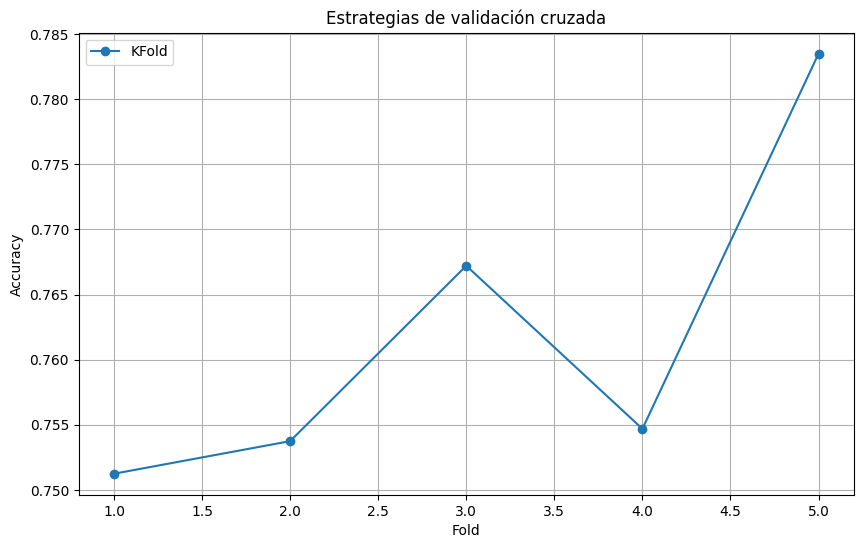

In [223]:
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()

In [224]:
results['KFold']

array([0.75125   , 0.75375   , 0.76720901, 0.75469337, 0.78347935])

In [225]:
for strategy in cv_strategies:
  print('Media para la estrategia', strategy[0],':',results['KFold'].mean())
  print('Desvío estándar para la estrategia', strategy[0],':',results['KFold'].std())

Media para la estrategia KFold : 0.7620763454317897
Desvío estándar para la estrategia KFold : 0.01204557169052212


# SHAP

### Explicabilidad Local

In [226]:
feature_names = X_train.columns.values
explainer = shap.LinearExplainer(logistic_model, X_train, feature_names=feature_names)

In [227]:
shap_values = explainer.shap_values(X_test)
explainer.expected_value

-0.4682451182851341

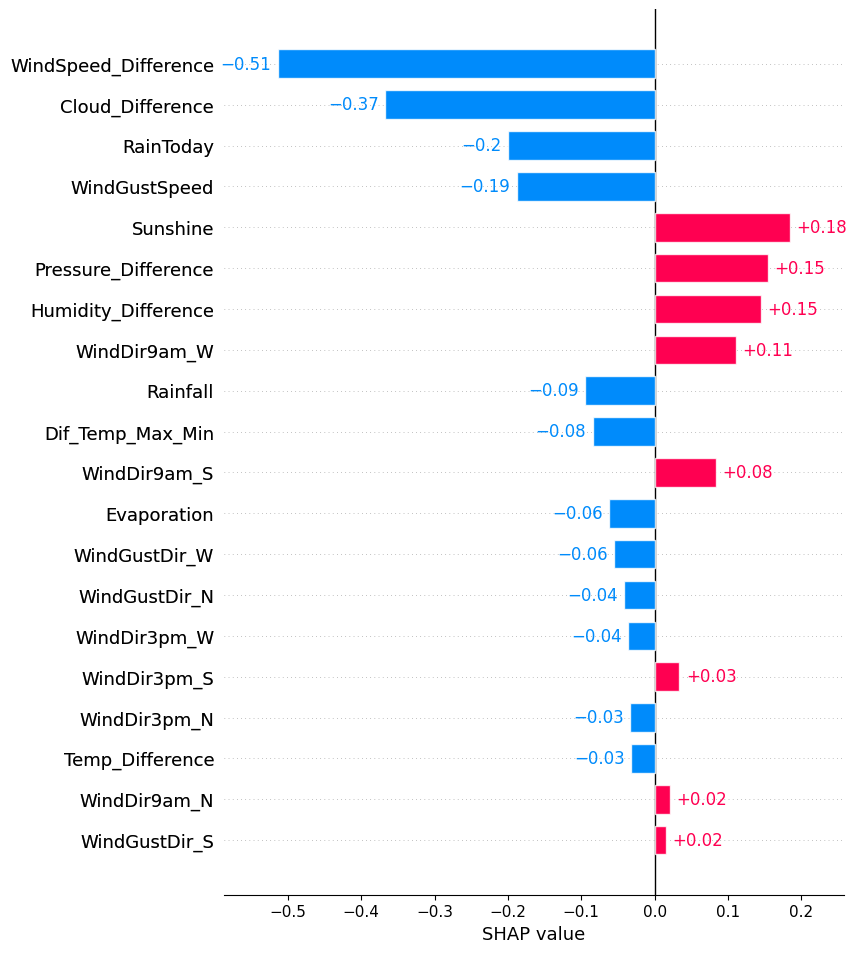

In [228]:
explanation = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.bar(explanation, max_display=21)

A nivel local, **WindSpeed_Diference** y **Cloud_Difference** son las variables que mas impactan sobre la prediccion de **RainTomorrow**

### Explicabilidad global

In [229]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_rl)

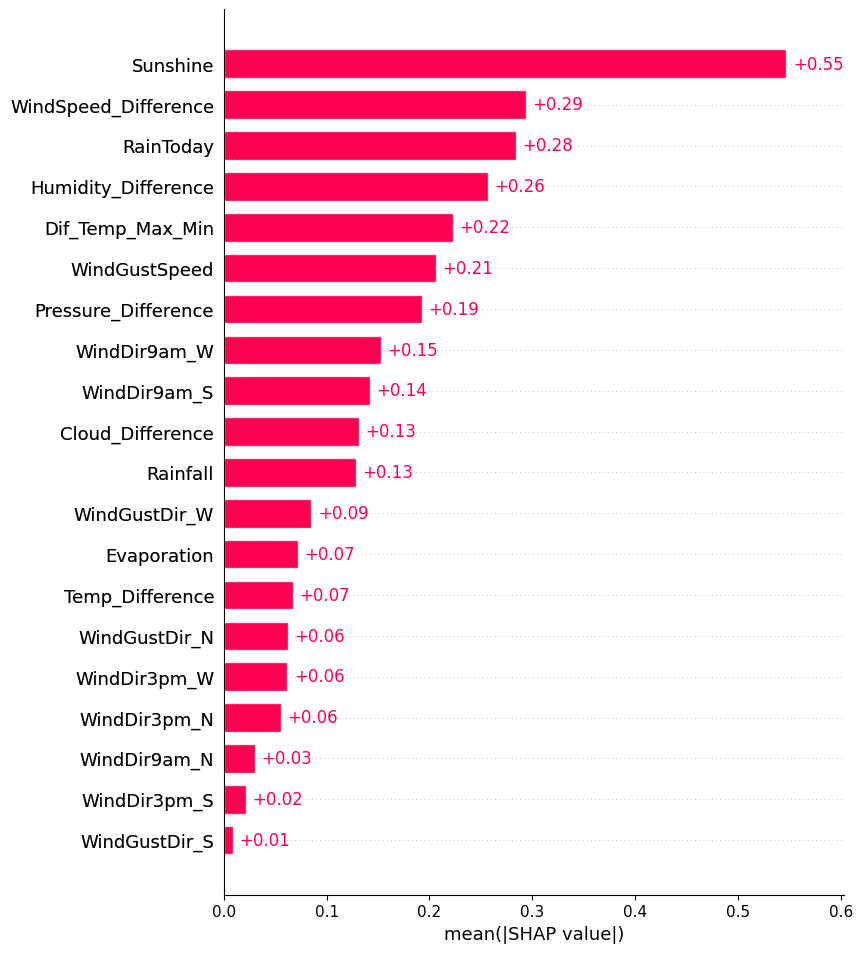

In [230]:
shap.plots.bar(explanation, max_display=21)

Las variables de mayor importancia a nivel global son **Sunshine** y **WindSpeed_Difference**, esta ultima tambien observada en la explicabilidad local.

# Redes Neuronales

In [231]:
import tensorflow as tf

In [232]:
class NeuralNetworkTensorFlow:
    """
        Este es un modelo simple con TensorFlow para resolver el mismo problema. 
        En esta clase, (1) se construye el modelo.
        (2) Se define como se fitea el modelo
        (3) Y como se hacen las predicciones.
    """
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        """
            Construye el modelo
            Para construir el modelo es necesario una arquitectura, un optimizador y una función de pérdida.
            La arquitectura se construye con el método Sequential, que basicamente lo que hace es colocar 
            secuencialmente las capas que uno desea.
            Las capas "Dense" son las fully connected dadas en clase.
            Se agrega una capa oculta que recibe un input de tamaño 2,
            y una capa de salida de regresión (una única neurona)
            En todos los casos se define una sigmoidea como función de activación (prueben otras!)

            El optimizador y la función de pérdida se especifican dentro de un compilador.

            Con este método, lo que se devuelve es el modelo sin entrenar, sería equivalente a escribir LinearRegression() 
            en el caso de la regresión lineal.
        """

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(2, activation='sigmoid', input_shape=(20,)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        ### imprimimos la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model
    
    def fit(self, X, y, lr=0.1, epochs=20000):
        ### esta es la función donde se entrena el modelo, fijarse que hay un learning rate e iteraciones.
        ### la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución.
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=epochs, verbose=0)
        return history.history['loss']

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

### Regresion Lineal

In [235]:
print(f'MSE: {mse}')

MSE: 0.9115786536040195


In [237]:
nn_tensorflow = NeuralNetworkTensorFlow()
loss_history = nn_tensorflow.fit(X_train, y_train, lr=0.1, epochs=100)

n° de parámetros: 45


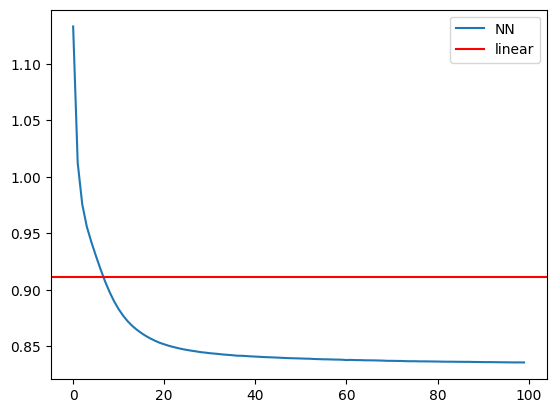

In [238]:
plt.plot(loss_history, label='NN')
plt.axhline(mse, color='red', label='linear',linestyle = '-')
plt.legend()
plt.show()

#### Optimizacion de hiperparametros

In [239]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [240]:
def objective(trial):

    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128) # la cantidad de neuronas de cada capa tambien se puede pasar como hiperparámetro
        # activations = trial.suggest_categorical(f'')
        model.add(Dense(num_units, activation='sigmoid')) # capas densas con activacion ReLU

    # capa de salida
    model.add(Dense(1)) # 3 son las clases de salida

    # compilar
    model.compile(optimizer='Adagrad', loss='categorical_crossentropy', metrics=['mse'])

    epochs = trial.suggest_int('epochs', 5, 100)

    # entrenar
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, verbose=0)

    # evaluar
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [241]:
# crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# obtener los mejores hiperparámetros
best_params = study.best_params
print("Best parámetros encontrados:", best_params)

[I 2024-06-24 17:36:49,614] A new study created in memory with name: no-name-0fc2381e-6426-4291-aa90-174a75b10c41
c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
[I 2024-06-24 17:36:53,039] Trial 0 finished with value: 1.003671407699585 and parameters: {'num_layers': 3, 'n_units_laye

Best parámetros encontrados: {'num_layers': 2, 'n_units_layer_0': 106, 'n_units_layer_1': 99, 'epochs': 53}


Al utilizar optuna, obtuve diferentes resultados, voy a quedarme con el siguiente.
Mejores parámetros encontrados: {'num_layers': 3, 'n_units_layer_0': 54, 'n_units_layer_1': 95, 'n_units_layer_2': 92, 'epochs': 29}

Nueva clase de nn_tensorflow con hiperparametros ajustados

In [242]:
import tensorflow as tf
import numpy as np

class NeuralNetworkTensorFlowOpt:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        num_layers = 3
        n_units_layer_0 = 54
        n_units_layer_1 = 95

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(n_units_layer_0, activation='sigmoid', input_shape=(20,)))

        for _ in range(1, num_layers):
            model.add(tf.keras.layers.Dense(n_units_layer_1, activation='sigmoid'))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='mean_squared_error')
        
        ### imprimimos la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model
    
    def fit(self, X, y, lr=0.1, epochs=29):
        ### esta es la función donde se entrena el modelo, fijarse que hay un learning rate e iteraciones.
        ### la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución.
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=epochs, verbose=0)
        return history.history['loss']

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions


In [243]:
nn_tensorflowOpt = NeuralNetworkTensorFlowOpt()
loss_history_opt = nn_tensorflowOpt.fit(X_train, y_train, lr=0.1, epochs=29)

c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


n° de parámetros: 15575


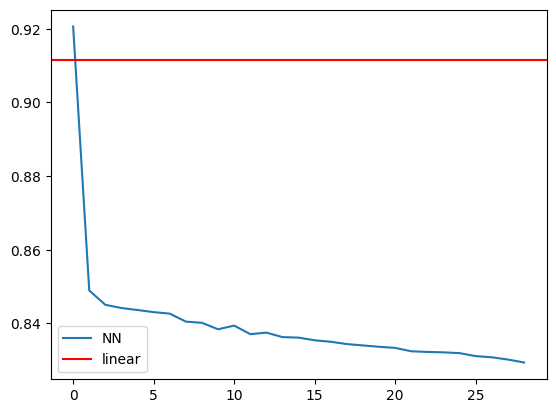

In [244]:
plt.plot(loss_history_opt, label='NN')
plt.axhline(mse, color='red', label='linear',linestyle = '-')
plt.legend()
plt.show()

Puedo apreciar que en esta ocacion se logra obtener un valor de MSE menor al obtenido en el modelo de Regresion Lineal implementado anteriormente.

### Regresion Logistica

In [245]:
print(f'Precisión obtenida en el modelo implemtado anteriormente: {accuracy_logreg}')

NameError: name 'accuracy_logreg' is not defined

Utilizo el y_train_rl generado en la seccion de Regresion Logistica ya que tiene valores 1 y 0 correspondientes a cada clase.

Defino una nueva funcion objetivo adaptandola a un modelo de clasificacion.

In [246]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [247]:
def objective(trial):

    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128) # la cantidad de neuronas de cada capa tambien se puede pasar como hiperparámetro
        # activations = trial.suggest_categorical(f'')
        model.add(Dense(num_units, activation='relu')) # capas densas con activacion ReLU

    # capa de salida
    model.add(Dense(1, activation='sigmoid')) # 2 son las clases de salida

    # compilar
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Sugerir el número de epochs como hiperparámetro
    epochs = trial.suggest_int('epochs', 5, 50)

    # entrenar
    model.fit(X_train, y_train_lg, validation_data=(X_test, y_test_lg), epochs=5, batch_size=32, verbose=0)

    # evaluar
    score = model.evaluate(X_test, y_test_lg, verbose=0)
    return score[1]

In [248]:
# crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# obtener los mejores hiperparámetros
best_params = study.best_params
print("Best parámetros encontrados:", best_params)

[I 2024-06-24 17:40:04,263] A new study created in memory with name: no-name-2d3c315f-4f46-4998-919a-a905b386217b
[W 2024-06-24 17:40:04,269] Trial 0 failed with parameters: {'num_layers': 1, 'n_units_layer_0': 37, 'epochs': 26} because of the following error: NameError("name 'y_train_lg' is not defined").
Traceback (most recent call last):
  File "c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Francisco\AppData\Local\Temp\ipykernel_17344\1507308733.py", line 21, in objective
    model.fit(X_train, y_train_lg, validation_data=(X_test, y_test_lg), epochs=5, batch_size=32, verbose=0)
                       ^^^^^^^^^^
NameError: name 'y_train_lg' is not defined
[W 2024-06-24 17:40:04,270] Trial 0 failed with value None.


NameError: name 'y_train_lg' is not defined

Mejores parámetros encontrados: {'num_layers': 3, 'n_units_layer_0': 41, 'n_units_layer_1': 24, 'n_units_layer_2': 83, 'epochs': 39}

In [249]:
# modelo de red neuronal
model = Sequential()
model.add(Dense(90, activation='relu'))  # Capa oculta con 38 neuronas y función de activación ReLU
model.add(Dense(90, activation='relu'))  # Capa oculta con 38 neuronas y función de activación ReLU
# model.add(Dense(38, activation='relu'))  # Capa oculta con 38 neuronas y función de activación ReLU
model.add(Dense(1, activation='sigmoid'))  # Capa de salida con 1 neurona  y función de activación sigmoid

In [250]:
# modelo de red neuronal
model = Sequential()
model.add(Dense(38, activation='relu'))  # Capa oculta con 38 neuronas y función de activación ReLU
model.add(Dense(38, activation='relu'))  # Capa oculta con 38 neuronas y función de activación ReLU
model.add(Dense(38, activation='relu'))  # Capa oculta con 38 neuronas y función de activación ReLU
model.add(Dense(1, activation='sigmoid'))  # Capa de salida con 1 neurona  y función de activación sigmoid

In [251]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [252]:
model.fit(X_train, y_train_rl, epochs=48, batch_size=32, validation_data=(X_test, y_test_rl))

Epoch 1/48
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8046 - loss: 0.4400 - val_accuracy: 0.8161 - val_loss: 0.4203
Epoch 2/48
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.8297 - loss: 0.3891 - val_accuracy: 0.8269 - val_loss: 0.4067
Epoch 3/48
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - accuracy: 0.8359 - loss: 0.3741 - val_accuracy: 0.8267 - val_loss: 0.4033
Epoch 4/48
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.8348 - loss: 0.3757 - val_accuracy: 0.8290 - val_loss: 0.4005
Epoch 5/48
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.8285 - loss: 0.3769 - val_accuracy: 0.8288 - val_loss: 0.4030
Epoch 6/48
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.8345 - loss: 0.3744 - val_accuracy: 0.8269 - val_loss: 0.4071
Epoch 7/48
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - accuracy: 0.8394 - loss: 0.3684 - val_accuracy: 0.8279 - val_loss: 0.4060
Epoch 8/48
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - accuracy: 0.8403 - loss: 0.3670 - va

In [253]:
# Hacer predicciones
y_pred2_rn = model.predict(X_test)
y_pred = (y_pred2_rn > 0.5).astype(int)  # Clasificación binaria

# Métricas para el modelo sin optimización
f1_score_rn = f1_score(y_test_rl, y_pred, average='weighted')

print(f"F1 Score del modelo: {f1_score_rn}")

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
F1 Score del modelo: 0.7994159066609574


Métricas para logreg:
Accuracy balanceado: 0.7152712680772837
Matriz de confusión:
[[2903  368]
 [ 483  574]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3271
           1       0.61      0.54      0.57      1057

    accuracy                           0.80      4328
   macro avg       0.73      0.72      0.72      4328
weighted avg       0.80      0.80      0.80      4328



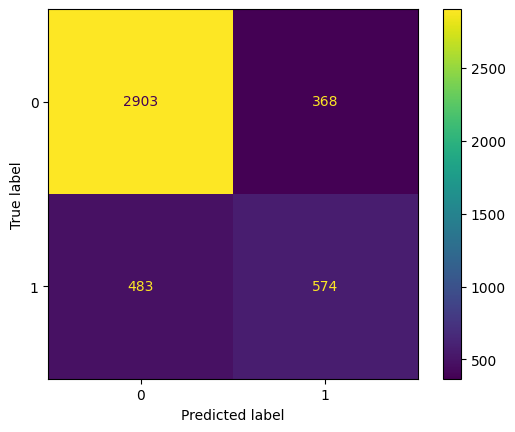

In [254]:
# Calcular métricas
balanced_accuracy = balanced_accuracy_score(y_test_rl, y_pred)
# accuracy_logreg = accuracy_score(y_train_rl, y_pred_train_rl)
confusion_matrix_logreg = confusion_matrix(y_test_rl, y_pred)
classification_report_logreg = classification_report(y_test_rl, y_pred)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Accuracy balanceado: {balanced_accuracy}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_logreg)
disp.plot()
plt.show()

Usando redes neuronales para clasificar, obtuve valores muy similares a los obtenidos en el modelo implementado anteriormente, los valores de **F1 Score** para cada clase se encuentran casi invariantes.

### SHAP

#### Explicabilidad Local

In [255]:
background = X_train.sample(100)

In [256]:
feature_names = X_train.columns.values
explainer = shap.KernelExplainer(model, background)

In [257]:
shap_values = explainer.shap_values(instance_to_explain)
explainer.expected_value

NameError: name 'instance_to_explain' is not defined

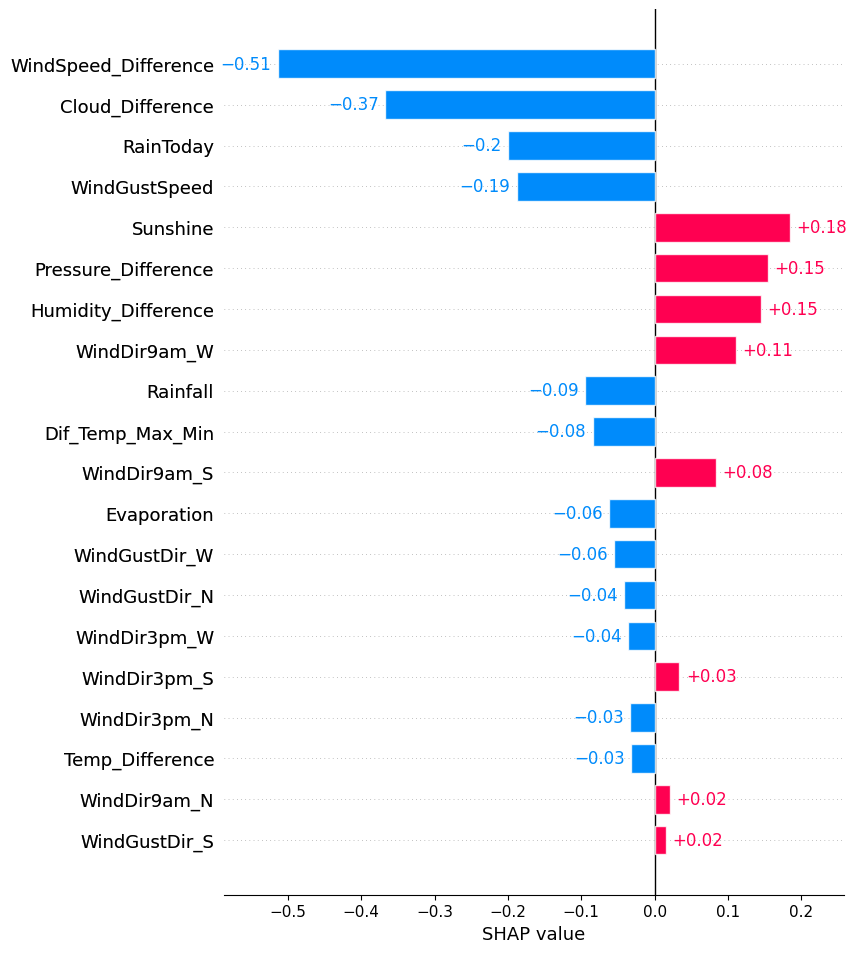

In [258]:
explanation = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.bar(explanation, max_display=21)

A nivel local, **WindSpeed_Diference** y **Cloud_Difference** son las variables que mas impactan sobre la prediccion de **RainTomorrow**

#### Explicabilidad global

In [259]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_rl)

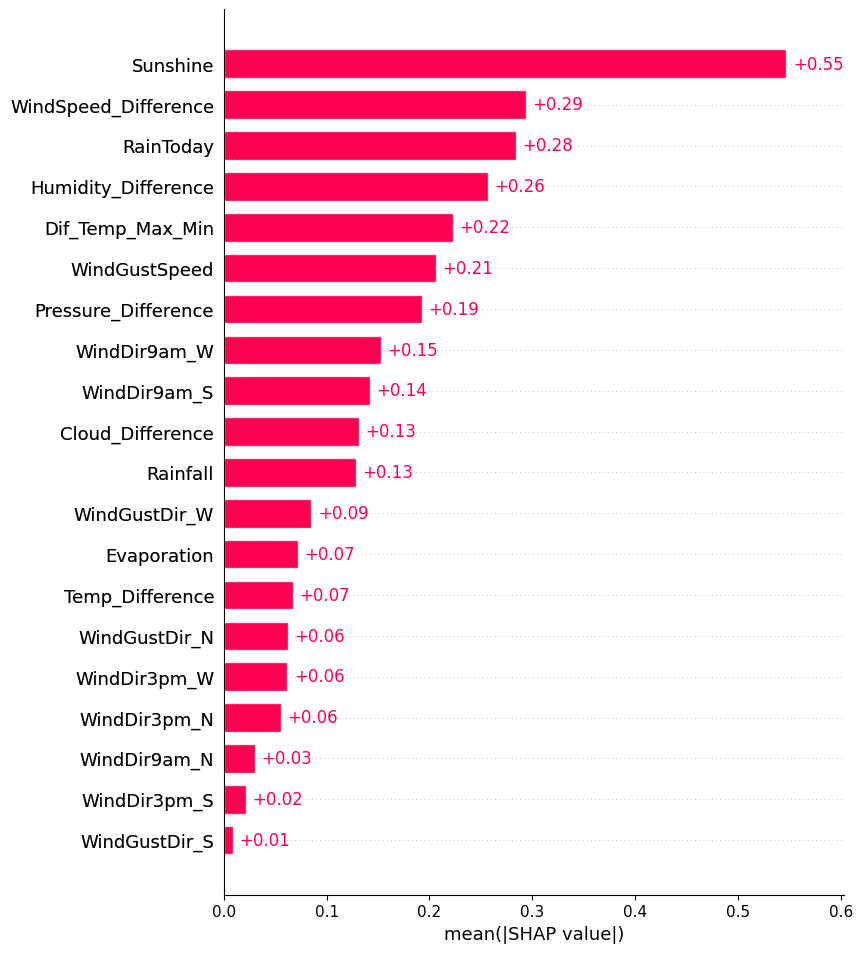

In [260]:
shap.plots.bar(explanation, max_display=21)

Las variables de mayor importancia a nivel global son **Sunshine** y **WindSpeed_Difference**, esta ultima tambien observada en la explicabilidad local.

In [261]:
# Crear un conjunto de muestras de fondo
background = X_train.sample(100)  
# Crear el objeto explainer SHAP utilizando KernelExplainer
explainer = shap.KernelExplainer(model, background)
instance_to_explain = X_test.iloc[0:1].values  # Seleccionar la línea 0
# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


In [262]:
# Obtener el valor esperado (base value)
expected_value = explainer.expected_value
# Hacer predicciones
index = 0  # índice de la instancia que queremos explicar
predicted_proba = model.predict(X_test)[index]  # Predicción de probabilidad
predicted_class = np.argmax(predicted_proba)  # Clase predicha

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


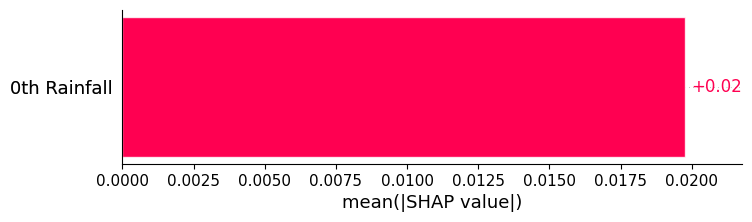

In [263]:
# Crear la explicación para la instancia específica
explanation = shap.Explanation(values=shap_values[0], base_values=expected_value, feature_names=feature_names)

# Visualizar la explicación
shap.initjs()
shap.plots.bar(explanation, max_display=len(feature_names))